# Water Mission, IBM

This Notebook offers analytics of water consumption for households in Busiro, Kikondo, and Dei districts of Uganda. It helps to create and update the monthly report from World Bank Data Project. You can find list of the report sections created using this notebook in _The Table of Content_ section below.

The Notebook processes the dataset from Uganda's districts. We assume, that dataset is a separate Excel file for each district. It should have at least 1 sheet with data named "Transaction log". 

To update the dataset you should add new Excel file into Oblect Storage and write its name into proper file container. 

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
 * [Common Figure Rendering Options](#rendering)
* [Data Pre-processing](#preprocessing)
 * [DataFrames Creation](#dataframes)
 * [Functions](#section3)
 * [Data preparation](#section4)
* [Report Data Calculation](#report)
 * [Section 7 Credit Deposit and Withdrawal Transactions](#section1)
 * [Section 8 Overall Water Consumption and Trends](#section5)



<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud. 

If you run the notebook on your local system set **environment** variable to **_local_** and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).

In [1]:
environment = 'bluemix'
root = 'c:\\sparknotes\\'
districts = ['Busiro', 'Kikondo', 'Dei', 'Chanhumba'] # Do not change
pattern = r'[a-z]' # Do not change

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
#@hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Uganda Transaction logs.xlsx'
}

In [3]:
auth_url = credentials['auth_url']
container = credentials['container']
username = credentials['username']
domain_id = credentials['domain_id']
password= credentials['password']

<a id="imports"></a>
## Library Imports

In [4]:
import time
import math
from __future__ import division, print_function
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from operator import itemgetter
import pylab
from io import BytesIO
import requests
import json
import pandas as pd

from matplotlib import mlab
from __future__ import print_function
import calendar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="rendering"></a>
## Common Figure Rendering Options

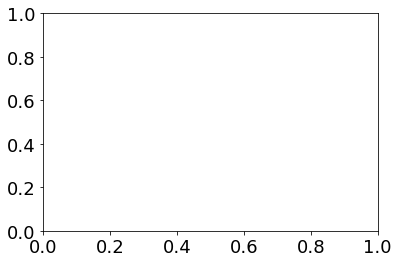

In [5]:
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=18)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [15, 7]
plt.rcParams["figure.figsize"] = fig_size

<a id="preprocessing"></a>
# Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="dataframes"></a>
## DataFrames Creation
In this section we load dataset file from and create DataFrame instances for the districts from corresponding tabs in the file.

In [6]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([auth_url, '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': username,'domain': {'id': domain_id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url)

The next section defines the dataset to be analyzed: for each site we define a list of files to be loaded and processed. When new data is available, add the files in the corresponding lists.

In [7]:
files_Chanhumba = ['Tanzania Transaction logs - Chanhumba.xlsx']
files_Busiro = ['Uganda Transaction logs - Busiro.xlsx']
files_Kikondo = ['Uganda Transaction logs - Kikondo.xlsx']
files_Dei = ['Uganda Transaction logs - Dei.xlsx']

sheet_name = 'Transaction log' # name of the tab, that contains transaction data

The readFiles function loads files from the specified list and returns a single DataFrame object with aggregated data.

In [8]:
def readFiles(files):
    frames = []
    for file in files:
        xls = pd.ExcelFile(get_file_content(file))
        frames.append(xls.parse(sheet_name))
    return pd.concat(frames)

In [9]:
waterUsageRDD_Kikondo = readFiles(files_Kikondo)
waterUsageRDD_Busiro = readFiles(files_Busiro)
waterUsageRDD_Dei = readFiles(files_Dei)
waterUsageRDD_Chanhumba = readFiles(files_Chanhumba)

<a id="section3"></a>
## Functions
This section defines functions used for data pre-processing.

In [10]:
def movingAverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    
    data = []
    values_sum = 0
      
    if(window > len(values)):
        smas = np.convolve(values, weights, 'same')
        return smas[:len(values)]
        
    for i in range (0,window-1):
        values_sum = values_sum + values[i]
        value = values_sum / (i+1)
        data.append(value)
    
    for i in sma:
        data.append(i)
        
    return data

In [11]:
# get max interval between transactions (use for stopped cards determining)
def calculateInterval(card, district):
    percentage = 5
    data = cardsHistory[cardsHistory.District == district]
    cardData = data[data.Smartcard_1 == card]
     
    initAr = list(cardData.Date)

    ar = (len(initAr) - 1) * [0]
    
    for index in range(len(initAr) - 1):
        ar[index] = (initAr[index+1] - initAr[index]).days
    ar.sort()
    
    values = 2
    if(len(ar) * percentage / 100) > 2:
        values = int(round(len(ar) * percentage / 100) )
    
    if(values > len(ar)):
        values = len(ar)
    
    if(values  == 0):
        maxIntervalOfUsage = 0
    else:
        maxIntervalOfUsage = round(sum(ar[-values:])/values)
    
    if(maxIntervalOfUsage > 0):
        if(maxIntervalOfUsage < 30):
            maxIntervalOfUsage = 30
    
    return maxIntervalOfUsage

def getInterval(x):
    card = x[0] 
    district = x[1] 
    return calculateInterval(card, district)

def findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge):
    res = 'Running'
    if ((endDate - lastUsageDate).days > interval):
        if (float(lastBalance) > balanceLowerEdge):
            res = 'Stopped with credits'
        else:
            res = 'Stopped without credits'
    
    return res

# get card status: Running, stopped with credits or stopped without credits 
def getStatus(x):
    card = x[0] 
    district = x[1] 
    endDate = x[2]
    lastUsageDate = x[3]
    lastBalance = x[4]
    interval = x[5]
    return findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge)

# find how many times card was renewed, what is the average amount of deposit, min balance before deposit and average balance before deposit 
def getCreditInfoByDistrict(district):
    data = getCardDataByDistrict(district)    
    data.Balance = data.Balance.astype(float).fillna(0)
    data.Credits = data.Credits.astype(float).abs().fillna(0)
    d1 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Balance.min().reset_index()
    d2 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Credits.sum().reset_index()
    df = pd.merge(d1, d2, on = ['Smartcard_1','Date', 'Date_and_time'])
    df.Date_and_time = pd.to_datetime(df.Date_and_time)
    df = df.sort_values(['Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True])
    df['Balance_diff'] = df.groupby('Smartcard_1')['Balance'].diff().fillna(0)
    df = df[(df.Balance_diff > 0)]
    df.Credits = df.Credits + df.Balance_diff
    df['Balance_prev'] = df.Balance - df.Balance_diff
    prevMin = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].min()
    prevAve = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].mean()
    count = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_diff'].count()
    ave = df[df.Balance_diff > 0].groupby('Smartcard_1')['Credits'].mean()
    result = pd.concat([count, ave, prevMin, prevAve], axis = 1).reset_index()
    result = result.fillna(0)
    result.columns = ['Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean']
    return result

In [12]:
def getTimeDiff(x):
    d1 = x[3]
    d2 = x[4]
    d3 = x[5]
    if(pd.notnull(d2)):
        return d1 - d2
    if(pd.notnull(d3)):
        return d3 - d1
    return d2

def getTimeDiff2(x):
    d1 = x[3]
    d2 = x[4]
    d3 = x[5]
    return d3 - d1

In [13]:
def creditGroup(y):
    x = abs(y)
    if (x >= 0) & (x < 25):
        return 1
    if (x >= 25) & (x < 50):
        return 2
    if (x >= 50) & (x < 75):
        return 3
    if (x >= 75) & (x < 100):
        return 4
    if (x >= 100) & (x < 125):
        return 5
    if (x >= 125) & (x < 150):
        return 6
    if (x >= 150) & (x < 175):
        return 7
    if (x >= 175) & (x < 200):
        return 8
    if (x >= 200) & (x < 225):
        return 9
    if (x >= 225) & (x < 250):
        return 10
    if (x >= 250) & (x < 275):
        return 11
    if (x >= 275) & (x < 300):
        return 12
    if (x >= 300):
        return 13
  
    return 0

In [14]:
def adjustDate(last_use, max_date, max_inactivity_days):
    delta = max_date - last_use
    return max_date if delta.days <= max_inactivity_days else last_use

def loadWaterTransactionData(initial_df):
    df = initial_df.copy()
    df = df[~df['Smartcard 1'].isnull()]
    if(df['Date and time'].dtype != 'datetime64[ns]'):
        df['Date and time'] = df['Date and time'].str.slice(0,10).str.replace('-', '.')
        df['Date and time'] = pd.to_datetime(df['Date and time'], format='%d.%m.%Y')
    else:
        df['Date and time'] = df['Date and time'].dt.date
    if(df['Smartcard 1'].dtype != 'object'):
        df['Smartcard 1'] = df['Smartcard 1'].astype(int).astype(str)    
    df = df[(df['Smartcard 1'].str.contains(pattern) != True) & (df['Smartcard 1'] != '')]  
    df = df[df['Operation'] == 'Water dispensed']
    df['Smartcard 1'] = df['Smartcard 1'].astype(int)
    df = df[~df['Smartcard 1'].isin({1603, 1604, 1605, 2281, 2283, 2284, 2291, 2292, 2954})]
    df = df[['Transaction id', 'Date and time', 'Smartcard 1', 'Water dispensed', 'Credits', 'Balance', 'Operation', 'Dispenser']]
    df['year'] = pd.DatetimeIndex(df['Date and time']).year
    df['month'] = pd.DatetimeIndex(df['Date and time']).month
    df['day'] = pd.DatetimeIndex(df['Date and time']).day
    df['isoyear'] = pd.DatetimeIndex(df['Date and time']).year
    df['isoweek'] = pd.DatetimeIndex(df['Date and time']).week
    df['weekday'] = pd.DatetimeIndex(df['Date and time']).weekday
    df.columns = ['transaction', 'date', 'smartcard', 'amount', 'credits', 'balance', 'operation', 'dispenser', 'year', 'month', 'day', 'isoyear', 'isoweek', 'weekday']
    
    return df

def prepareTransactionData(initial_df):
    df = loadWaterTransactionData(initial_df)
    
    byday1 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.sum()
    byday2 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).smartcard.nunique()
    byday3 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.count()
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
    byday.columns = ['isoyear', 'isoweek', 'date', 'weekday', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
  
    # calc the last date
    last_date = np.max(df.date)
    card_last_day = df.groupby(['smartcard']).date.max().reset_index()
    card_last_day.columns = ['smartcard', 'last_date']
    # update last date for 'non-stopped' cards
    card_last_day['last_date'] = card_last_day['last_date'].apply(adjustDate, args=(last_date, 28))
    
    # total cards in the dataset
    total_num = len(df.smartcard.drop_duplicates())
    pdf = byday
    # add number of non-stopped cards into dataframe
    pdf['active_cards'] = 0
    pdf['inactive_cards'] = 0
    pdf['amount_per_active_card'] = 0
    for i in pdf.index:
        row = pdf.ix[i]
        active_num = card_last_day[(card_last_day.last_date >= row.date)].smartcard.count()
        pdf.ix[i, 'active_cards'] = active_num
        pdf.ix[i, 'inactive_cards'] = total_num - active_num
        pdf.ix[i, 'amount_per_active_card'] = row.amount / active_num
    
    return pdf

def trimInitialWeeks(pdf, numOfWeeks):
    minyear = np.min(pdf['isoyear'])
   
    minweek = np.min(pdf[pdf.isoyear == minyear].isoweek)
    
    maxweek = np.max(pdf[pdf.isoyear == minyear].isoweek)
   
    if (maxweek - minweek > numOfWeeks):
        pdf = pdf[((pdf.isoyear == minyear)&(pdf.isoweek >= minweek + numOfWeeks)) | (pdf.isoyear > minyear)]
        size = len(pdf)
        pdf.index = range(0, size)
    else:
        print ('Need to handle situation with year changed')
    
    return pdf

def getTableData(comm):
    df = resultset[resultset.District == comm]
    df.Date = pd.to_datetime(df.Date)
    print('overall transactions = ', df.Transaction_id.count().round(0))
    print('overall water dispensed = ', round(df.Water_dispensed.sum(), 0))
    print('average daily water dispensed = ',  round(df.groupby(['Date']).Water_dispensed.sum().reset_index().Water_dispensed.mean(), 0))
    df1 = df.groupby(['Date']).Water_dispensed.sum().reset_index()
    df2 = df.groupby(['Date']).Smartcard_1.nunique().reset_index()
    df3 = pd.merge(df1, df2, on = ['Date'])
    df3['WaterPerUniqueCard'] = df3.Water_dispensed / df3.Smartcard_1
    print('average daily amount per unique card = ',  round(df3.WaterPerUniqueCard.mean(), 0))
    df['year'] = df.Date.dt.year
    df['month'] = df.Date.dt.month
    df1 = df.groupby(['year','month']).Smartcard_1.nunique()
    df2 = df.groupby(['year','month']).Transaction_id.count()
    df3 = df.groupby(['year','month','Date']).Water_dispensed.sum().reset_index().groupby(['year','month']).Water_dispensed.mean().round(0)
    df = pd.concat([df1, df2, df3], axis = 1).reset_index()
    df.columns = ['year', 'month', 'number of unique cards', 'monthly transaction count', 'monthly average daily water dispensed']
    return df

def getCardDataByDistrict(district):
    if(district == 'Busiro'):
        return waterUsageDF_Busiro
    if(district == 'Kikondo'):
        return waterUsageDF_Kikondo
    if(district == 'Dei'):
        return waterUsageDF_Dei
    if(district == 'Chanhumba'):
        return waterUsageDF_Chanhumba

<a id="section4"></a>
## Data preparation

Remove rows with empty 'Smartcard 1' values, drop duplicates, convert date and time, add district name

In [15]:
def cleanData(waterUsageDF, districtName):
    waterUsageDF = waterUsageDF[~waterUsageDF['Smartcard 1'].isnull()]
    if(waterUsageDF['Smartcard 1'].dtype != 'object'):
        waterUsageDF['Smartcard 1'] = waterUsageDF['Smartcard 1'].astype(int).astype(str)   
    waterUsageDF_2 = waterUsageDF[(waterUsageDF['Smartcard 1'].str.contains(pattern) != True) & (waterUsageDF['Smartcard 1'] != '')]
    waterUsageDF_2.columns = ['Transaction_id','Date_and_time','Dispenser','Operation','Smartcard_1','Smartcard_2','Water_dispensed','Credits','Balance','Total_created']
    waterUsageDF_2 = waterUsageDF_2.drop_duplicates().reset_index(drop=True)
    
    waterUsageDF_2.Date_and_time = pd.to_datetime(waterUsageDF_2.Date_and_time, format='%d-%m-%Y %H:%M:%S')
    waterUsageDF_2['Date'] = waterUsageDF_2.Date_and_time.dt.date
    waterUsageDF_2.Date = pd.to_datetime(waterUsageDF_2.Date, format='%Y-%m-%d')
    
    waterUsageDF_2['District'] = districtName
    
    return waterUsageDF_2

In [16]:
waterUsageDF_Busiro = cleanData(waterUsageRDD_Busiro, 'Busiro')
waterUsageDF_Kikondo = cleanData(waterUsageRDD_Kikondo, 'Kikondo')
waterUsageDF_Dei = cleanData(waterUsageRDD_Dei, 'Dei')
waterUsageDF_Chanhumba = cleanData(waterUsageRDD_Chanhumba, 'Chanhumba')

Let's move transactions for 'vendor' cards into a separate set, and remove them from the dataset

In [17]:
vendor_cards = {'1604', '1605', '2281', '2283', '2284', '2291', '2292', '2954'}
vendors = waterUsageDF_Kikondo[waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)] 
vendors = vendors.append(waterUsageDF_Busiro[waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)])

waterUsageDF_Busiro = waterUsageDF_Busiro[~waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)] 
waterUsageDF_Kikondo = waterUsageDF_Kikondo[~waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)]

Save datasets with all types of operation for future

In [18]:
waterUsageDF_Busiro_allOperations = waterUsageDF_Busiro
waterUsageDF_Kikondo_allOperations = waterUsageDF_Kikondo
waterUsageDF_Dei_allOperations = waterUsageDF_Dei
waterUsageDF_Chanhumba_allOperations = waterUsageDF_Chanhumba

allOperations = waterUsageDF_Busiro_allOperations.append(waterUsageDF_Kikondo_allOperations).append(waterUsageDF_Dei).append(waterUsageDF_Chanhumba).append(vendors)
allOperations = allOperations[~allOperations.Smartcard_1.isnull()]

Let's remove from from the dataset all operations different to Water dispensed, and further clean the data

In [19]:
def cleanData2(waterUsageDF):
    waterUsageDF = waterUsageDF[(waterUsageDF.Operation == 'Water dispensed')]
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.replace(to_replace='.0', value='', regex=False)
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.astype(int).astype(str)
    waterUsageDF = waterUsageDF[(waterUsageDF.Smartcard_1 != '')]
    return waterUsageDF

In [20]:
waterUsageDF_Busiro = cleanData2(waterUsageDF_Busiro)
waterUsageDF_Kikondo = cleanData2(waterUsageDF_Kikondo)
waterUsageDF_Dei = cleanData2(waterUsageDF_Dei)
waterUsageDF_Chanhumba = cleanData2(waterUsageDF_Chanhumba)


Clean the aggregated data as well

In [21]:
allOperations.Smartcard_1 = allOperations.Smartcard_1.replace(to_replace='.0', value='', regex=False)
allOperations.Smartcard_2 = allOperations.Smartcard_2.replace(to_replace='.0', value='', regex=False)

allOperations.Smartcard_1 = allOperations.Smartcard_1.astype(int).astype(str)

allOperations = allOperations[(allOperations.Smartcard_1 != '')]

Prepare data related to credits

In [22]:
def prepareCreditsData(waterUsageDF, districtName):
    credits = getCreditInfoByDistrict(districtName)
    result = pd.merge(waterUsageDF, credits, on='Smartcard_1', how='left')
    result['District'] = districtName
    result['EndDate'] = waterUsageDF.Date.max()
    return result

busiroResult = prepareCreditsData(waterUsageDF_Busiro, 'Busiro')
kikondoResult = prepareCreditsData(waterUsageDF_Kikondo, 'Kikondo')
deiResult = prepareCreditsData(waterUsageDF_Dei, 'Dei')
chanhumbaResult = prepareCreditsData(waterUsageDF_Chanhumba, 'Chanhumba')

In [23]:
result = pd.DataFrame(busiroResult.append(kikondoResult).append(deiResult).append(chanhumbaResult), 
                columns=['Transaction_id','Date','Date_and_time','EndDate','District','Dispenser','Smartcard_1','Water_dispensed',
                'Credits','Balance','Credits_Add','Add_Credits_Mean','Balance_Before_Credit_Min','Balance_Before_Credit_Mean'])

transaction_Count = result.groupby(['District','Smartcard_1'])['Transaction_id'].count().reset_index()
water_dispensed_Mean = result.groupby(['District','Smartcard_1'])['Water_dispensed'].mean().reset_index()
first_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].min().reset_index()
last_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].max().reset_index()

d1 = pd.merge(transaction_Count, water_dispensed_Mean, on=['District','Smartcard_1'], how='left')
d2 = pd.merge(first_Usage_Date, last_Usage_Date, on=['District','Smartcard_1'], how='left')
additionalDB = pd.merge(d1, d2, on=['District','Smartcard_1'], how='left')
additionalDB.columns = ['District', 'Smartcard_1', 'Transaction_Count', 'Water_dispensed_Mean', 'First_Usage_Date', 'Last_Usage_Date']
resultset = pd.merge(result, additionalDB, on=['District','Smartcard_1'], how='left')

In [24]:
cardData1 = allOperations.groupby(['District','Smartcard_1', 'Date']).Water_dispensed.sum()
cardData2 = allOperations.groupby(['District','Smartcard_1', 'Date']).Balance.min()
cardDataRes = pd.concat([cardData1, cardData2], axis = 1).reset_index()
cardsHistory = cardDataRes.sort_values(['District','Smartcard_1', 'Date'], ascending=[True,True,True]).reset_index(drop=True)

lastBalance = cardsHistory.groupby(['District','Smartcard_1']).Balance.last().reset_index()
lastBalance.columns = ['District','Smartcard_1','LastBalance']

cardsMaxInterval = pd.DataFrame(lastBalance, columns=['Smartcard_1', 'District'], index = lastBalance.index).drop_duplicates().reset_index(drop=True)
cardsMaxInterval.loc[:,'Interval'] = cardsMaxInterval.apply(getInterval, axis = 1)

resultset = pd.merge(resultset, lastBalance, on=['District','Smartcard_1'], how='left')
resultset = pd.merge(resultset, cardsMaxInterval, on=['District','Smartcard_1'], how='left')
resultset.LastBalance = resultset.LastBalance.astype(float)

balanceLowerEdge = 15

cardsStatus = pd.DataFrame(resultset, columns=['Smartcard_1', 'District', 'EndDate', 
                                               'Last_Usage_Date', 'LastBalance', 'Interval'], index = resultset.index).drop_duplicates().reset_index(drop=True)
cardsStatus.loc[:,'Status'] = cardsStatus.apply(getStatus, axis = 1)

In [25]:
resultset = pd.merge(resultset, cardsStatus, on=['Smartcard_1', 'District', 'EndDate', 'Last_Usage_Date', 'LastBalance', 'Interval'], how='left')
resultset.LastBalance = resultset.LastBalance.fillna(0)
resultset['CreditGroup'] = pd.Series(resultset.Credits, index=resultset.index).apply(creditGroup)

<a id="report"></a>
# Report Data Calculation

<a id="section1"></a>
## Section 7 Credit Deposit and Withdrawal Transactions


Starting from May 2016 the data includes “deposit” transactions (in addition to water dispensed transactions). During May-April there were a lot of deposit transactions, marked ‘Credits deposited from WMS’ or ‘Credits deposited from card. 
There were many “zero credits” deposit transactions marked ‘Credits deposited from WMS’. 

This section provides some calculations about it.

In [26]:
deposits = allOperations[(allOperations.Operation.str.contains('deposit')) & (allOperations.Credits > 0)]
deposits = deposits[['District', 'Smartcard_1','Smartcard_2','Date', 'Date_and_time', 'Credits', 'Balance']]
deposits = deposits.sort_values(['District','Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True, True])
deposits.Credits = deposits.Credits.astype(float)
deposits = deposits.groupby(['District', 'Smartcard_1','Date']).Credits.sum().reset_index()

In [27]:
# number of deposit transactions
print('number of deposit transactions is ', len(deposits))

number of deposit transactions is  15291


In [28]:
# 'Credits deposited from WMS' operastions
print('\'Credits deposited from WMS\' operastions is ', len(allOperations[(allOperations.Operation == 'Credits deposited from WMS')]))

'Credits deposited from WMS' operastions is  5641


In [29]:
# 'Credits deposited from WMS' non-zero operastions
print('\'Credits deposited from WMS\' non-zero operastions is ', len(allOperations[(allOperations.Operation == 'Credits deposited from WMS') & (allOperations.Credits > 0)]))

'Credits deposited from WMS' non-zero operastions is  188


In [30]:
# number of cards with 'Credits deposited from WMS' non-zero operastions
cards_with_non_zero_ops = allOperations[
    (allOperations.Operation == 'Credits deposited from WMS') & 
    (allOperations.Credits != 0)].groupby(['District', 'Smartcard_1']).Transaction_id.count().reset_index()
print('number of cards with \'Credits deposited from WMS\' non-zero operastions is ', len(cards_with_non_zero_ops))

number of cards with 'Credits deposited from WMS' non-zero operastions is  49


In [31]:
# More than 2 transaction was made by cards_with_non_zero_ops:
d = cards_with_non_zero_ops.sort_values(['Transaction_id'])
d = d[d.Transaction_id > 2]
d.reset_index(drop=True).sort_values(['District'])

District Smartcard_1  Transaction_id
6   Busiro        2291              44
7   Busiro        2292              46
0      Dei       54338               3
3      Dei       15200               5
4      Dei       15202              12
1  Kikondo        2290               3
2  Kikondo        1826               4
5  Kikondo        2289              23

In [32]:
# number of cards, which transferred money to other cards at least 1 time.
df_operations = allOperations[allOperations.Operation.isin({'Credits deposited from WMS', 'Credits deposited from card' , 'Credits withdrawn'})]
df_operations = df_operations[['District', 'Operation', 'Smartcard_1', 'Smartcard_2', 'Credits', 'Balance', 'Date', 'Date_and_time']]
df_operations = df_operations.sort_values(['District','Date_and_time'], ascending=[True, True])
df_operations = df_operations[df_operations.Operation == 'Credits withdrawn']
df_operations = df_operations[['District', 'Operation', 'Smartcard_1', 'Smartcard_2']].reset_index(drop = True)
df_operationsFindCreditors = df_operations.drop_duplicates().reset_index(drop = True)
df_operationsFindCreditors = df_operationsFindCreditors.groupby(['District', 'Operation', 'Smartcard_1']).Smartcard_2.count().reset_index()
print('number of cards, which transferred money to other cards at least 1 time is ', len(df_operationsFindCreditors))
print('% ', len(df_operationsFindCreditors) / allOperations.Smartcard_1.nunique() * 100)
df_operationsFindCreditors.columns = ['District', 'Operation', 'Smartcard_1', 'NumberOfCorrespondedCards']
df_operationsFindCreditors.head(5)

number of cards, which transferred money to other cards at least 1 time is  310
%  25.74750830564784


District          Operation Smartcard_1  NumberOfCorrespondedCards
0   Busiro  Credits withdrawn        1681                        176
1   Busiro  Credits withdrawn        1684                          1
2   Busiro  Credits withdrawn        1691                          1
3   Busiro  Credits withdrawn        1692                          1
4   Busiro  Credits withdrawn        1697                          7

In [33]:
# number of cards transferred money to multiple cards
print('number of cards transferred money to multiple cards is ', len(df_operationsFindCreditors[df_operationsFindCreditors.NumberOfCorrespondedCards > 1]))


number of cards transferred money to multiple cards is  128


In [34]:
# cards transferred money to a huge amount of cards
df_operationsFindCreditors[df_operationsFindCreditors.NumberOfCorrespondedCards > 10].reset_index(drop=True)

District          Operation Smartcard_1  NumberOfCorrespondedCards
0      Busiro  Credits withdrawn        1681                        176
1      Busiro  Credits withdrawn        1834                        481
2      Busiro  Credits withdrawn        1844                         31
3      Busiro  Credits withdrawn        1902                        161
4      Busiro  Credits withdrawn        1911                         63
5      Busiro  Credits withdrawn        1950                        147
6      Busiro  Credits withdrawn        1968                        139
7      Busiro  Credits withdrawn        1970                         38
8      Busiro  Credits withdrawn        1980                         96
9      Busiro  Credits withdrawn        1983                         54
10     Busiro  Credits withdrawn        2291                        216
11     Busiro  Credits withdrawn        2292                        157
12     Busiro  Credits withdrawn        2929                        141
13     Busiro  Credits withdrawn        2933                        165
14     Busiro  Credits withdrawn        3040                         12
15     Busiro  Credits withdrawn        3115                         24
16  Chanhumba  Credits withdrawn       15694                         47
17  Chanhumba  Credits withdrawn       15701                         22
18  Chanhumba  Credits withdrawn       15789                         48
19  Chanhumba  Credits withdrawn       70198                         29
20  Chanhumba  Credits withdrawn       70361                         15
21  Chanhumba  Credits withdrawn       70897                         81
22  Chanhumba  Credits withdrawn       71074                         53
23        Dei  Credits withdrawn       15200                         61
24        Dei  Credits withdrawn       15202                        106
25        Dei  Credits withdrawn       54331                         47
26    Kikondo  Credits withdrawn        2289                        152
27    Kikondo  Credits withdrawn        2290                         94

Credits withdrawn  Credits deposited from card  No changes  \
Busiro-1834              6544.0                        394.0      2803.0   
Kikondo-2289             2518.0                          0.0      1076.0   
Dei-15202                1210.0                          0.0       748.0   
Busiro-1681               745.0                         81.0       378.0   
Busiro-2291               699.0                          0.0       495.0   
Busiro-2292               443.0                          0.0       332.0   
Busiro-1902               378.0                         42.0       260.0   
Busiro-2933               369.0                         73.0       276.0   
Kikondo-2290              307.0                          0.0       142.0   
Busiro-1950               286.0                         53.0       292.0   

              Water dispensed  Credits deposited from WMS  
Busiro-1834            2325.0                         6.0  
Kikondo-2289             16.0                       196.0  
Dei-15202               576.0                        48.0  
Busiro-1681             328.0                         4.0  
Busiro-2291               3.0                       160.0  
Busiro-2292               9.0                       121.0  
Busiro-1902               9.0                         0.0  
Busiro-2933             374.0                         0.0  
Kikondo-2290              6.0                        38.0  
Busiro-1950             273.0                         0.0

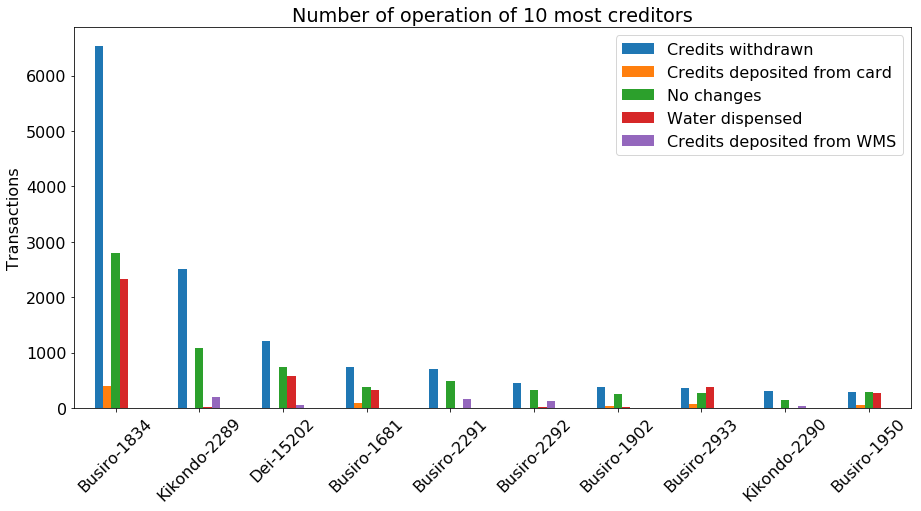

In [35]:
# operations of biggest creditors
allOperationsCreditorsCards = allOperations[allOperations.Smartcard_1.isin(list(df_operationsFindCreditors[df_operationsFindCreditors.NumberOfCorrespondedCards > 10].Smartcard_1))]
allOperationsCreditorsCards = allOperationsCreditorsCards.groupby(['District', 'Smartcard_1', 'Operation']).Transaction_id.count().reset_index()
allOperationsCreditorsCards1 = allOperationsCreditorsCards[allOperationsCreditorsCards.Operation == 'Credits deposited from card']
allOperationsCreditorsCards2 = allOperationsCreditorsCards[allOperationsCreditorsCards.Operation == 'Credits withdrawn']
allOperationsCreditorsCards3 = allOperationsCreditorsCards[allOperationsCreditorsCards.Operation == 'No changes']
allOperationsCreditorsCards4 = allOperationsCreditorsCards[allOperationsCreditorsCards.Operation == 'Water dispensed']
allOperationsCreditorsCards5 = allOperationsCreditorsCards[allOperationsCreditorsCards.Operation == 'Credits deposited from WMS']

allOperationsCreditorsCards = pd.merge(allOperationsCreditorsCards2[['District', 'Smartcard_1', 'Transaction_id']], 
                                       allOperationsCreditorsCards1[['District', 'Smartcard_1', 'Transaction_id']], on=['District', 'Smartcard_1'], how='outer').fillna(0)
allOperationsCreditorsCards = pd.merge(allOperationsCreditorsCards, 
                                       allOperationsCreditorsCards3[['District', 'Smartcard_1', 'Transaction_id']], on=['District', 'Smartcard_1'], how='outer').fillna(0)
allOperationsCreditorsCards = pd.merge(allOperationsCreditorsCards, 
                                       allOperationsCreditorsCards4[['District', 'Smartcard_1', 'Transaction_id']], on=['District', 'Smartcard_1'], how='outer').fillna(0)
allOperationsCreditorsCards = pd.merge(allOperationsCreditorsCards, 
                                       allOperationsCreditorsCards5[['District', 'Smartcard_1', 'Transaction_id']], on=['District', 'Smartcard_1'], how='outer').fillna(0)
allOperationsCreditorsCards.columns = ['District', 'Smartcard_1','Credits withdrawn', 'Credits deposited from card', 'No changes', 'Water dispensed', 'Credits deposited from WMS']
allOperationsCreditorsCards.index = allOperationsCreditorsCards["District"]  + "-" + allOperationsCreditorsCards["Smartcard_1"].astype(str)

allOperationsCreditorsCards = allOperationsCreditorsCards[['Credits withdrawn','Credits deposited from card','No changes','Water dispensed','Credits deposited from WMS']]
allOperationsCreditorsCards = allOperationsCreditorsCards.sort_values(['Credits withdrawn'], ascending = False)
allOperationsCreditorsCards = allOperationsCreditorsCards[:10]
ax = allOperationsCreditorsCards.plot(kind='bar',title='Number of operation of 10 most creditors');
ax.set_ylabel("Transactions")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

allOperationsCreditorsCards

<a id="section5"></a>
## Section 8 Overall Water Consumption and Trends

Here we prepare data for building some tables and charts appurtenant to Section 8 in the report.

In [36]:
getTableData('Busiro')

overall transactions =  98115
overall water dispensed =  1944500.0
average daily water dispensed =  4608.0
average daily amount per unique card =  51.0


year  month  number of unique cards  monthly transaction count  \
0   2016      2                     344                       4895   
1   2016      3                     332                       4687   
2   2016      4                     310                      10461   
3   2016      5                     295                       6482   
4   2016      6                     330                       8469   
5   2016      7                     335                      10623   
6   2016      8                     326                       9653   
7   2016      9                     319                       5071   
8   2016     10                      85                        703   
9   2016     11                     265                       5411   
10  2016     12                     310                       9847   
11  2017      1                     313                       8141   
12  2017      2                     280                       6507   
13  2017      3                     208                       4314   
14  2017      4                     191                       2851   

    monthly average daily water dispensed  
0                                  6469.0  
1                                  3990.0  
2                                  4090.0  
3                                  3664.0  
4                                  5402.0  
5                                  6974.0  
6                                  6350.0  
7                                  3618.0  
8                                   873.0  
9                                  4094.0  
10                                 6417.0  
11                                 6017.0  
12                                 4773.0  
13                                 2748.0  
14                                 2072.0

In [37]:
getTableData('Kikondo')

overall transactions =  121430
overall water dispensed =  1933995.0
average daily water dispensed =  2697.0
average daily amount per unique card =  52.0


year  month  number of unique cards  monthly transaction count  \
0   2015      4                       3                          5   
1   2015      5                     140                       3436   
2   2015      6                     132                       3933   
3   2015      7                     129                       4938   
4   2015      8                     127                       5486   
5   2015      9                     118                       4892   
6   2015     10                     113                       4819   
7   2015     11                     108                       6145   
8   2015     12                     106                       5943   
9   2016      1                     114                       5993   
10  2016      2                     112                       4482   
11  2016      3                     106                       5990   
12  2016      4                     104                       5504   
13  2016      5                     105                       7046   
14  2016      6                     107                       6347   
15  2016      7                     106                       3527   
16  2016      8                      96                       3491   
17  2016      9                     119                       5291   
18  2016     10                     110                       4104   
19  2016     11                     102                       4045   
20  2016     12                     109                       6139   
21  2017      1                      92                       4528   
22  2017      2                      90                       3640   
23  2017      3                      88                       6071   
24  2017      4                      82                       5635   

    monthly average daily water dispensed  
0                                    36.0  
1                                  3201.0  
2                                  3129.0  
3                                  3453.0  
4                                  3613.0  
5                                  3433.0  
6                                  3146.0  
7                                  2747.0  
8                                  2464.0  
9                                  3036.0  
10                                 2876.0  
11                                 2364.0  
12                                 2238.0  
13                                 2678.0  
14                                 2573.0  
15                                 2352.0  
16                                 2243.0  
17                                 2792.0  
18                                 2501.0  
19                                 2587.0  
20                                 3052.0  
21                                 2129.0  
22                                 2359.0  
23                                 2016.0  
24                                 1971.0

In [38]:
getTableData('Dei')

overall transactions =  29722
overall water dispensed =  339279.0
average daily water dispensed =  964.0
average daily amount per unique card =  43.0


year  month  number of unique cards  monthly transaction count  \
0   2016      4                      88                        768   
1   2016      5                      94                       3517   
2   2016      6                      78                       2038   
3   2016      7                      74                       3604   
4   2016      8                      70                       3176   
5   2016      9                      62                       1839   
6   2016     10                      69                       2052   
7   2016     11                      80                       2792   
8   2016     12                      80                       2457   
9   2017      1                      70                       2888   
10  2017      2                      58                       1640   
11  2017      3                      57                       1772   
12  2017      4                      50                       1179   

    monthly average daily water dispensed  
0                                  1382.0  
1                                  1544.0  
2                                   696.0  
3                                   881.0  
4                                   766.0  
5                                   705.0  
6                                   931.0  
7                                  1131.0  
8                                  1000.0  
9                                  1035.0  
10                                  877.0  
11                                  790.0  
12                                 1183.0

In [39]:
getTableData('Chanhumba')

overall transactions =  13404
overall water dispensed =  270775.0
average daily water dispensed =  6017.0
average daily amount per unique card =  57.0


year  month  number of unique cards  monthly transaction count  \
0  2017      5                     347                       8893   
1  2017      6                     241                       4511   

   monthly average daily water dispensed  
0                                 5783.0  
1                                 6536.0

In [40]:
ds1 = prepareTransactionData(waterUsageRDD_Kikondo)

ds2 = prepareTransactionData(waterUsageRDD_Busiro)

ds3 = prepareTransactionData(waterUsageRDD_Dei)

ds4 = prepareTransactionData(waterUsageRDD_Chanhumba)

datasets = {'Kikondo': ds1,\
            'Busiro': ds2,\
            'Dei': ds3,\
            'Chanhumba': ds4}

series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'},
          'Active Cards':{'field':'active_cards', 'measure':'Smartcards'},
          'Inactive Cards':{'field':'inactive_cards', 'measure':'Smartcards'},
          'Water Consumption / Active Card':{'field':'amount_per_active_card', 'measure':'Liters'}}

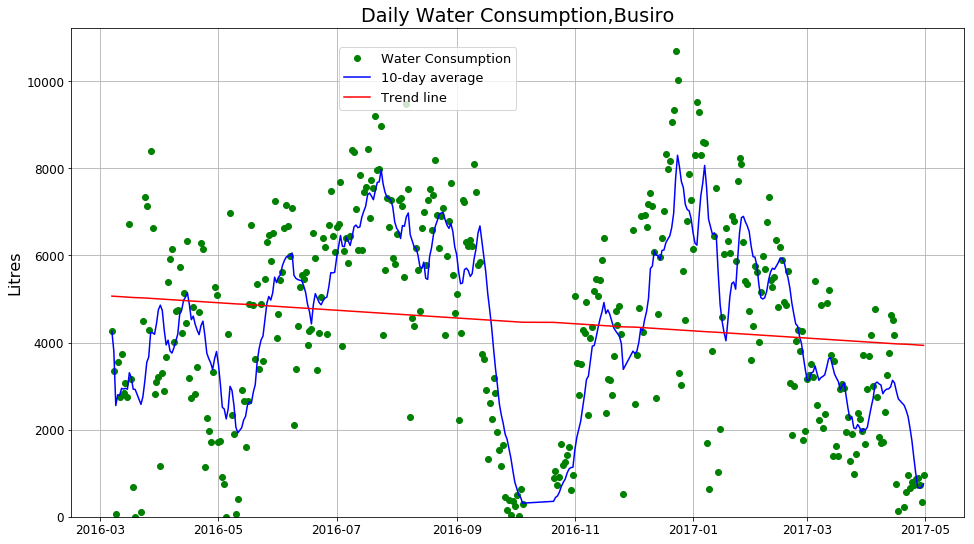

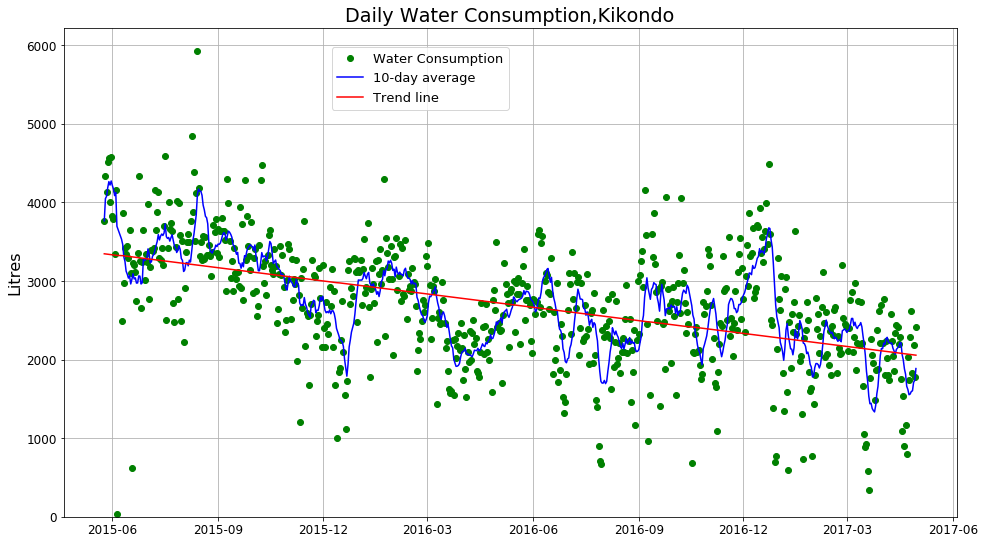

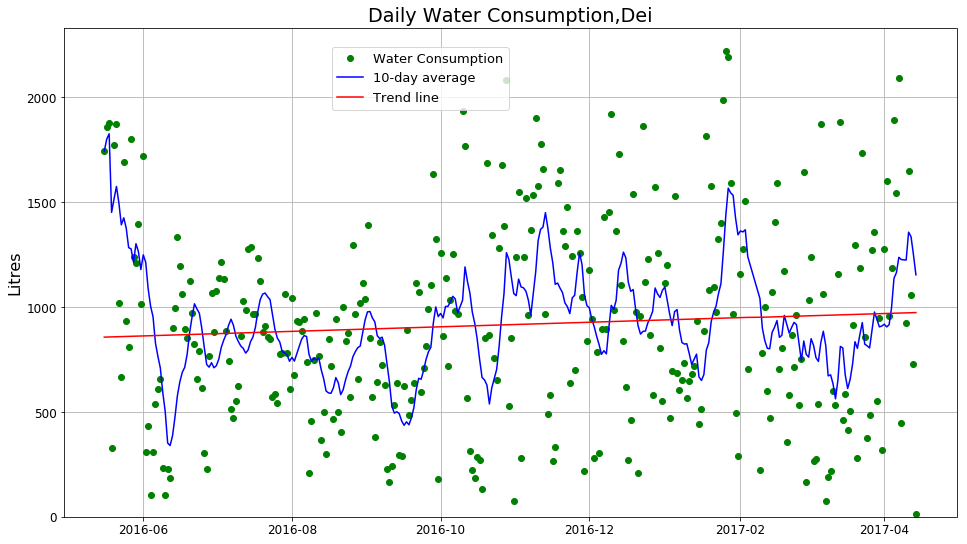

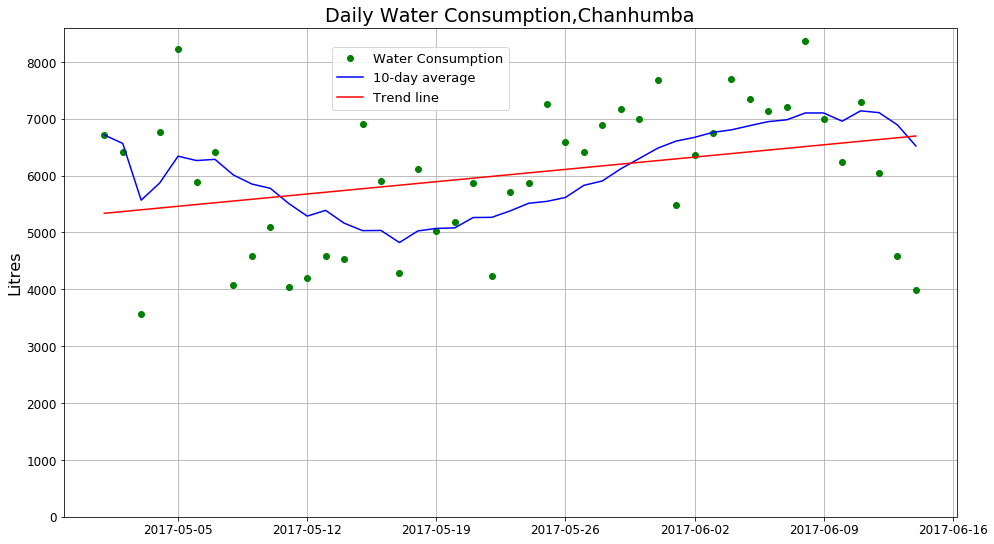

In [41]:
def showTrend(district, key, weeksToTrim, showAverage):
    data = trimInitialWeeks(datasets[district], int(weeksToTrim)).drop_duplicates()
    data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
    data = data.sort_values('date', ascending = True).reset_index(drop = True)
    x = data.date
    y = data[series[key]['field']]
    
    legend = list()

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(series[key]['measure'])

    plt.plot(x, y, 'go')
    legend.append(key)
    
    # calc 10-day average
    if showAverage:
        plt.plot(x, movingAverage(y, 10) ,"b-")
        legend.append("10-day average")
    
    # calc the trendline
    i = x.index
    z = np.polyfit(i, y, 1)
    p = np.poly1d(z)

    plt.plot(x, p(i),"r-")
    legend.append("Trend line")

    plt.legend(legend, bbox_to_anchor=(0.3, 0.96), loc=2, borderaxespad=0., fontsize=13)
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.title('Daily ' + key + ',' + district)
    plt.ylim(ymin=0)
    plt.show()
    
series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'},
          'Active Cards':{'field':'active_cards', 'measure':'Smartcards'},
          'Inactive Cards':{'field':'inactive_cards', 'measure':'Smartcards'},
          'Water Consumption / Active Card':{'field':'amount_per_active_card', 'measure':'Liters'}}
    

key = 'Water Consumption'
weeksToTrim = 4
showAverage = True

for d in districts:
    if(d == 'Chanhumba'):
        showTrend(d, key, 0, showAverage)
    else:
        showTrend(d, key, weeksToTrim, showAverage)

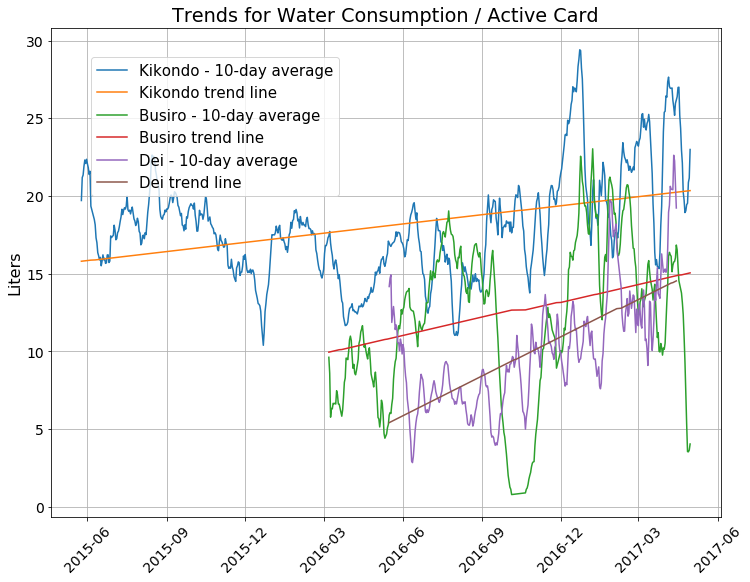

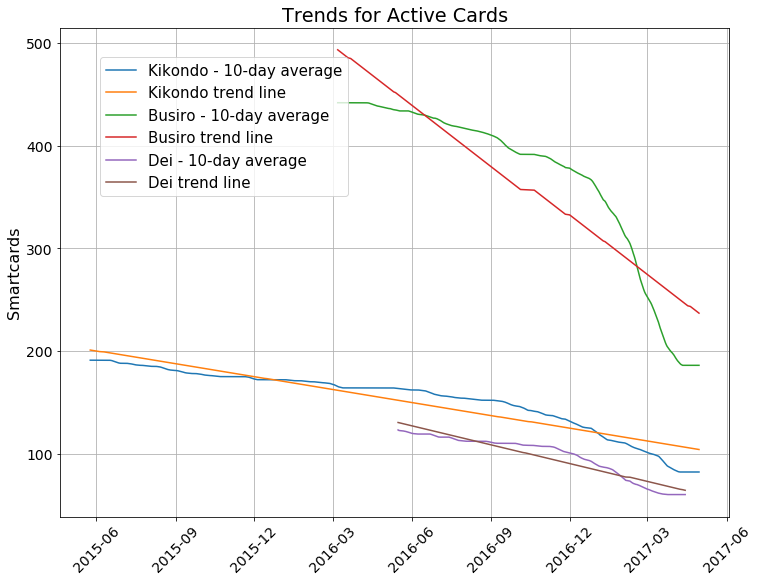

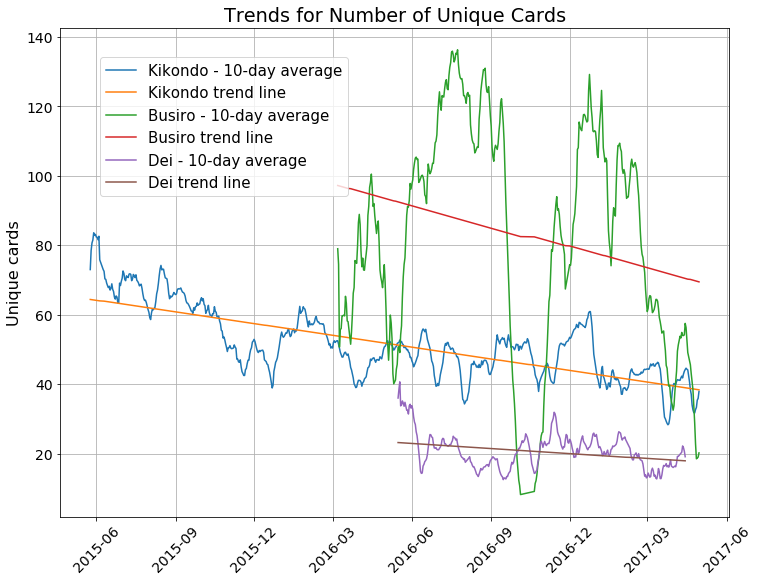

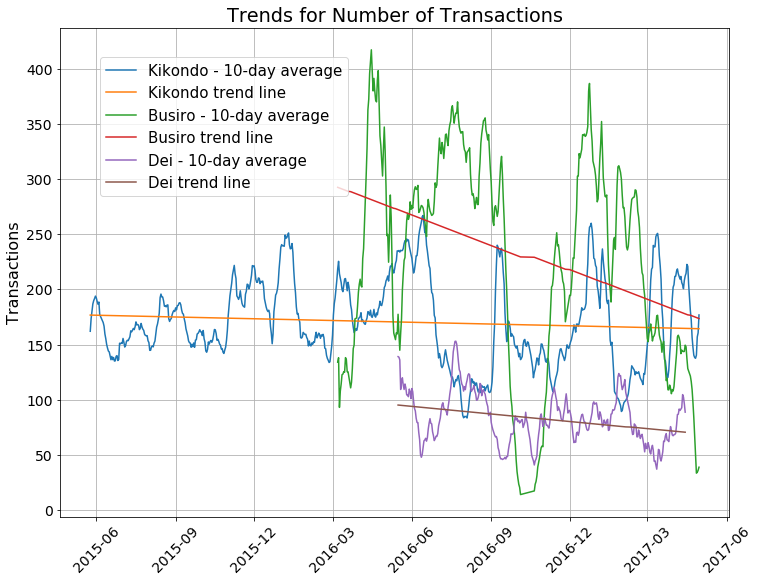

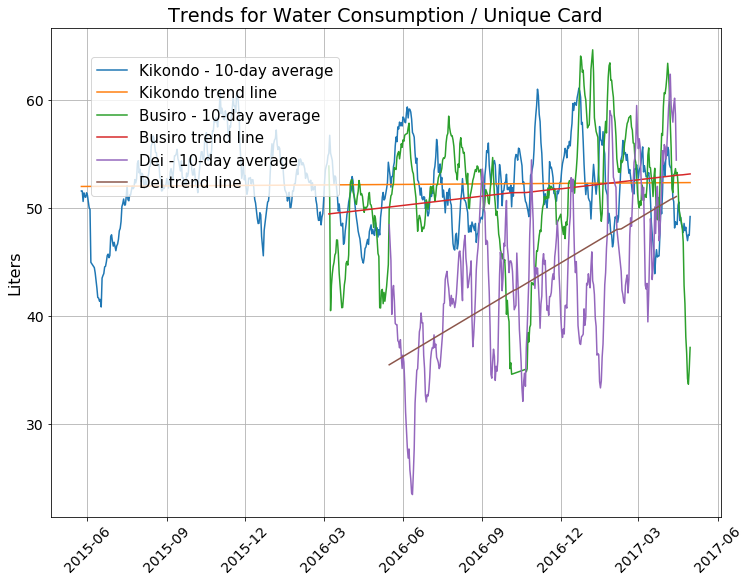

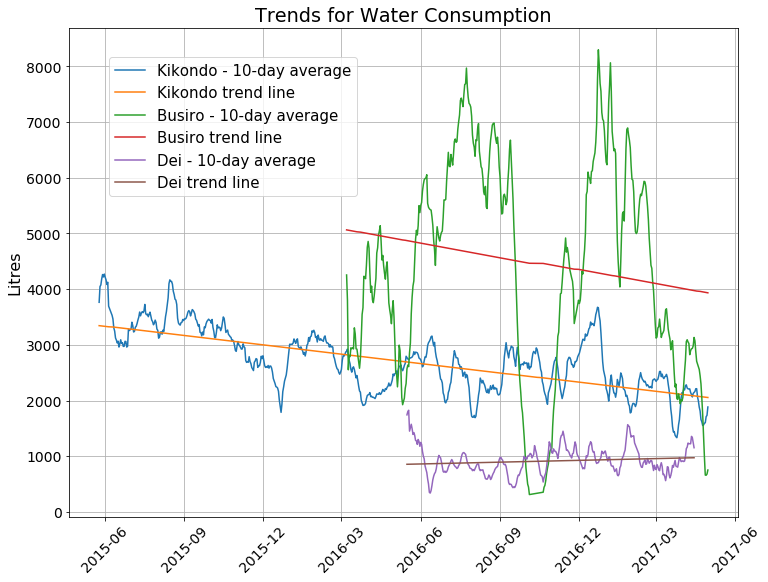

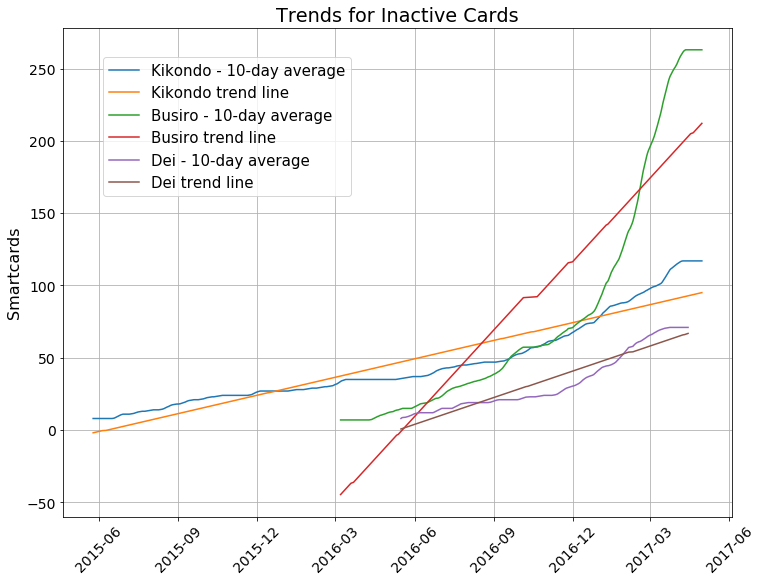

In [42]:
def showTrendForAllLocations(key, weeksToTrim, showAverage, showPoints, showLegend):
    legend = list()
    for district in datasets.keys():
        if(district != 'Chanhumba'):
            data = trimInitialWeeks(datasets[district], int(weeksToTrim))
            data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
            data = data.sort_values('date', ascending = True).reset_index(drop = True)        
            x = data.date
            y = data[series[key]['field']]

            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 12
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
            ax = plt.axes()
            ax.yaxis.grid(True)
            ax.xaxis.grid(True)
            ax.set_ylabel(series[key]['measure'])

            if showPoints:
                plt.plot(x, y, '-')
                legend.append(district)

            # calc 10-day average
            if showAverage:
                plt.plot(x, movingAverage(y, 10) ,"-")
                legend.append(district + " - 10-day average")

            # calc the trendline
            i = x.index
            z = np.polyfit(i, y, 1)
            p = np.poly1d(z)

            t = data.index.map(lambda x: p(x))
            plt.plot(x, p(i),"-")
            legend.append(district + ' trend line')
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Trends for ' + key)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    if(showLegend):
        plt.legend(legend, bbox_to_anchor=(0.06, 0.94), loc=2, borderaxespad=0., fontsize=15)
    
    plt.show()

    #return data
series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'},
          'Active Cards':{'field':'active_cards', 'measure':'Smartcards'},
          'Inactive Cards':{'field':'inactive_cards', 'measure':'Smartcards'},
          'Water Consumption / Active Card':{'field':'amount_per_active_card', 'measure':'Liters'}}

weeksToTrim = 4
showAverage = True
showPoints = False
showLegend = True

for s in series:
    showTrendForAllLocations(s, weeksToTrim, showAverage, showPoints, showLegend)

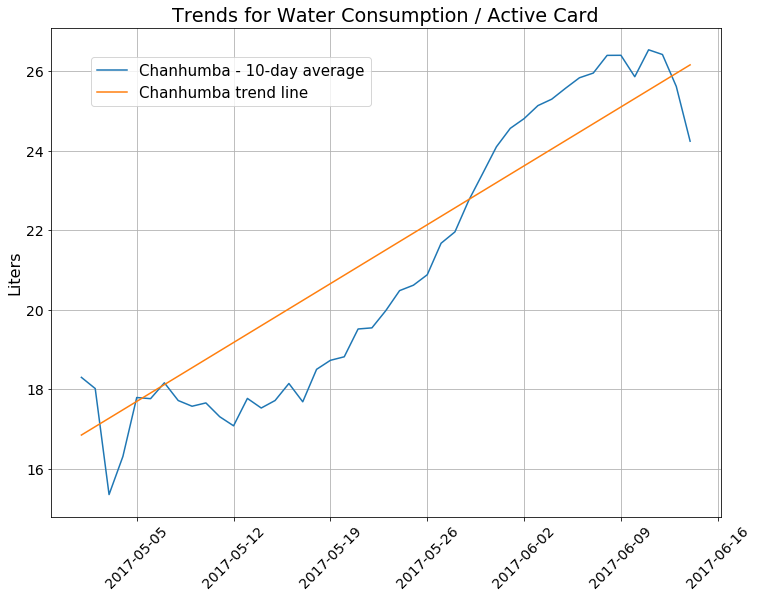

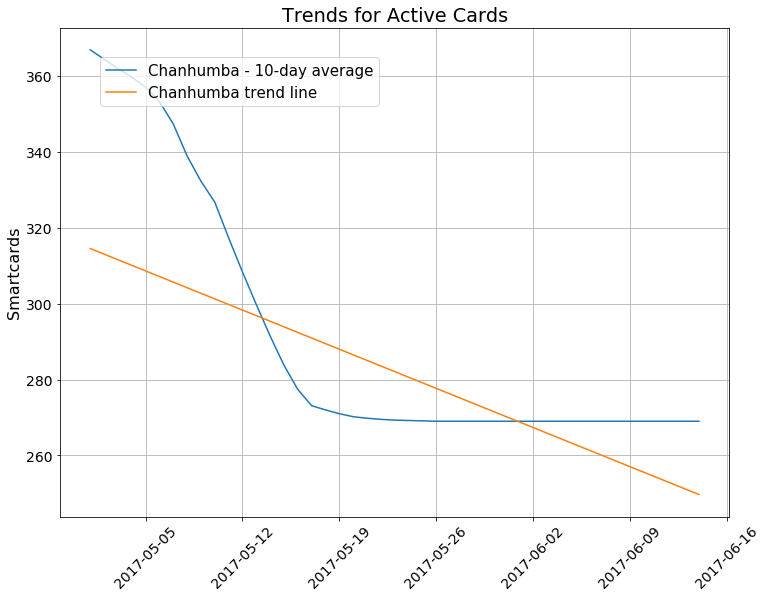

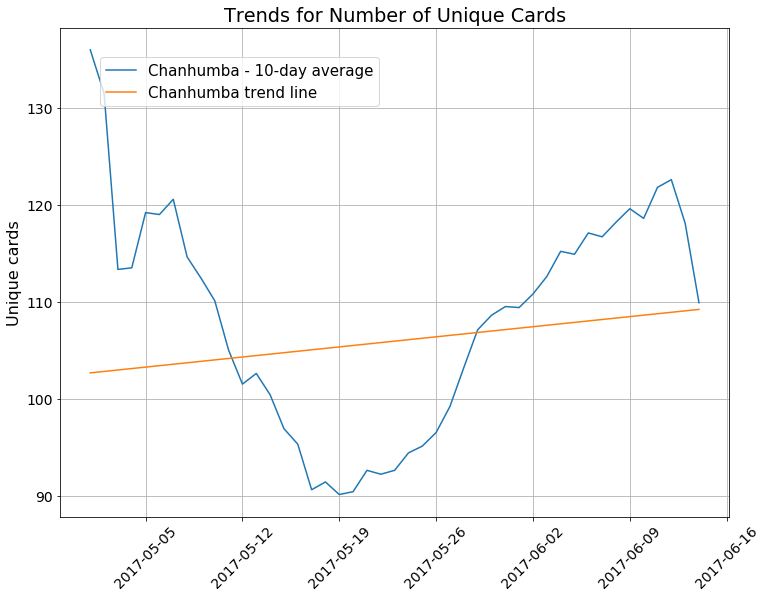

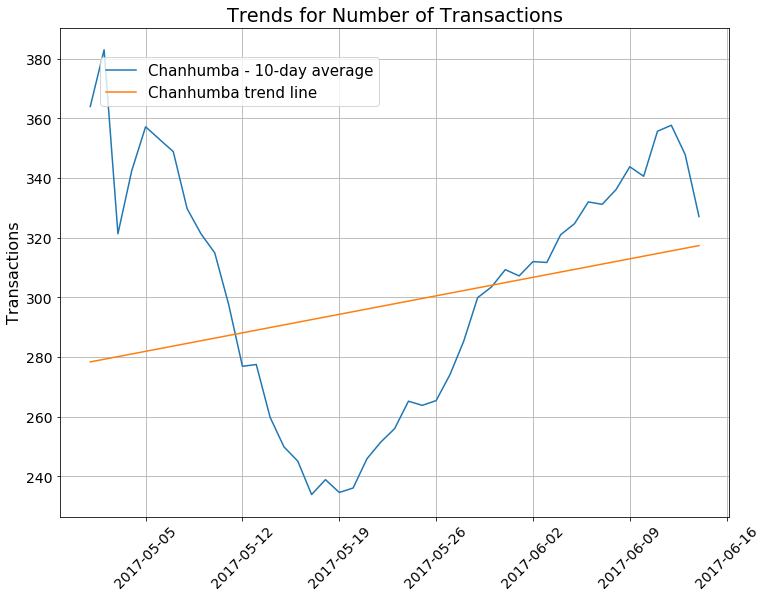

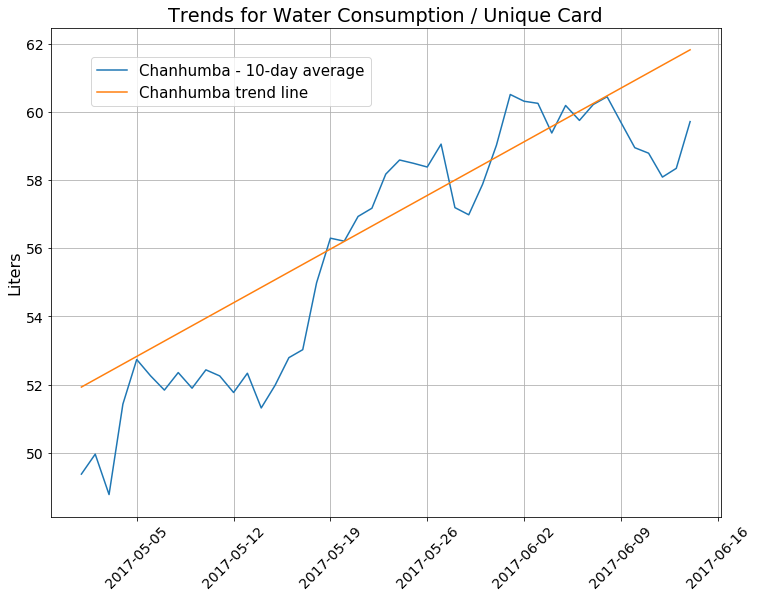

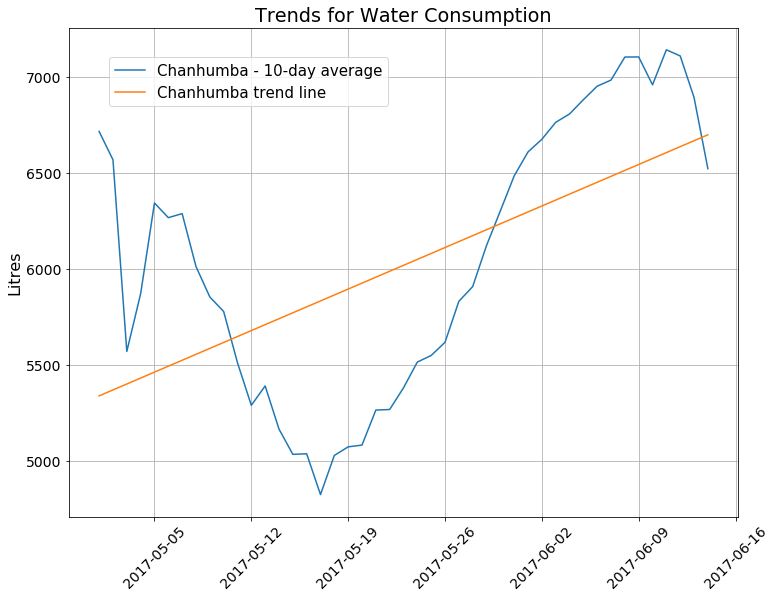

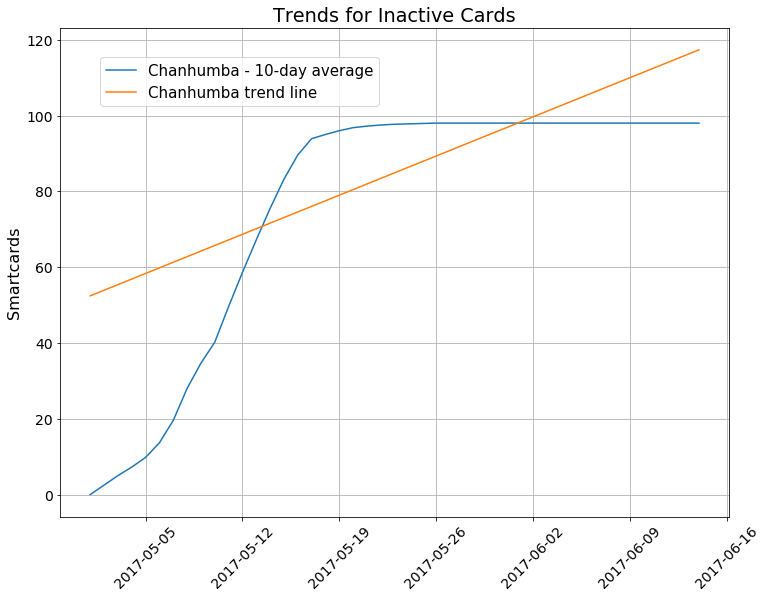

In [43]:
def showTrendForChanhumbaLocation(key, weeksToTrim, showAverage, showPoints, showLegend):
    legend = list()
    for district in datasets.keys():
        if(district == 'Chanhumba'):
            data = trimInitialWeeks(datasets[district], int(weeksToTrim))
            data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
            data = data.sort_values('date', ascending = True).reset_index(drop = True)        
            x = data.date
            y = data[series[key]['field']]

            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 12
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
            ax = plt.axes()
            ax.yaxis.grid(True)
            ax.xaxis.grid(True)
            ax.set_ylabel(series[key]['measure'])

            if showPoints:
                plt.plot(x, y, '-')
                legend.append(district)

            # calc 10-day average
            if showAverage:
                plt.plot(x, movingAverage(y, 10) ,"-")
                legend.append(district + " - 10-day average")

            # calc the trendline
            i = x.index
            z = np.polyfit(i, y, 1)
            p = np.poly1d(z)

            t = data.index.map(lambda x: p(x))
            plt.plot(x, p(i),"-")
            legend.append(district + ' trend line')
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Trends for ' + key)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    if(showLegend):
        plt.legend(legend, bbox_to_anchor=(0.06, 0.94), loc=2, borderaxespad=0., fontsize=15)
    
    plt.show()

    #return data
series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'},
          'Active Cards':{'field':'active_cards', 'measure':'Smartcards'},
          'Inactive Cards':{'field':'inactive_cards', 'measure':'Smartcards'},
          'Water Consumption / Active Card':{'field':'amount_per_active_card', 'measure':'Liters'}}

weeksToTrim = 0
showAverage = True
showPoints = False
showLegend = True

for s in series:
    showTrendForChanhumbaLocation(s, weeksToTrim, showAverage, showPoints, showLegend)

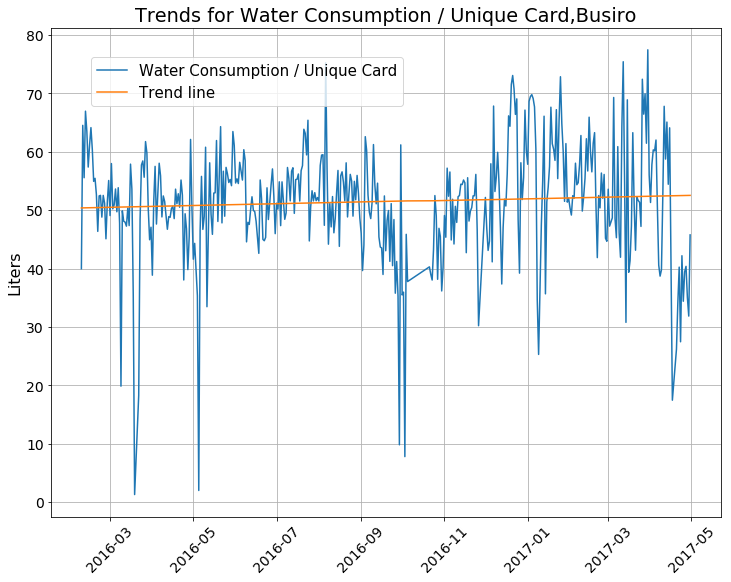

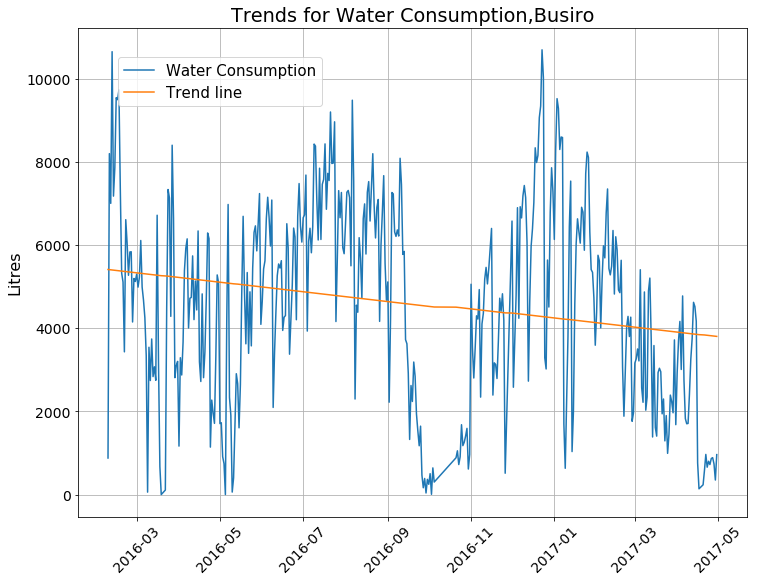

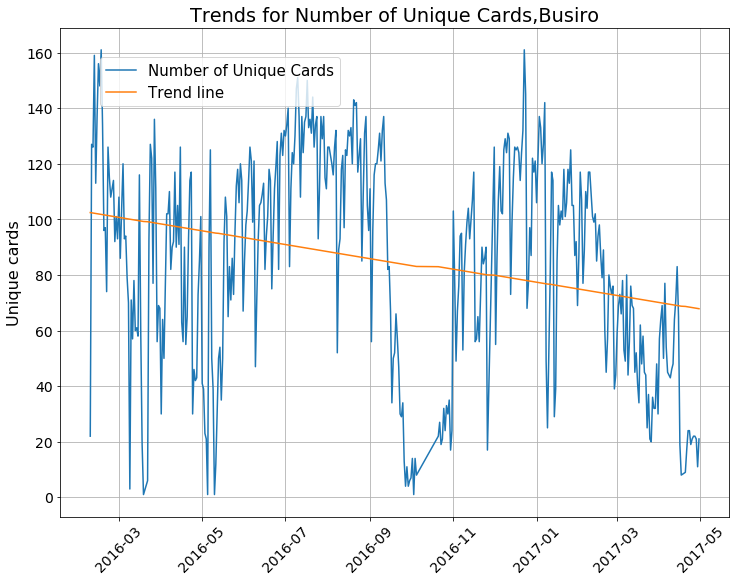

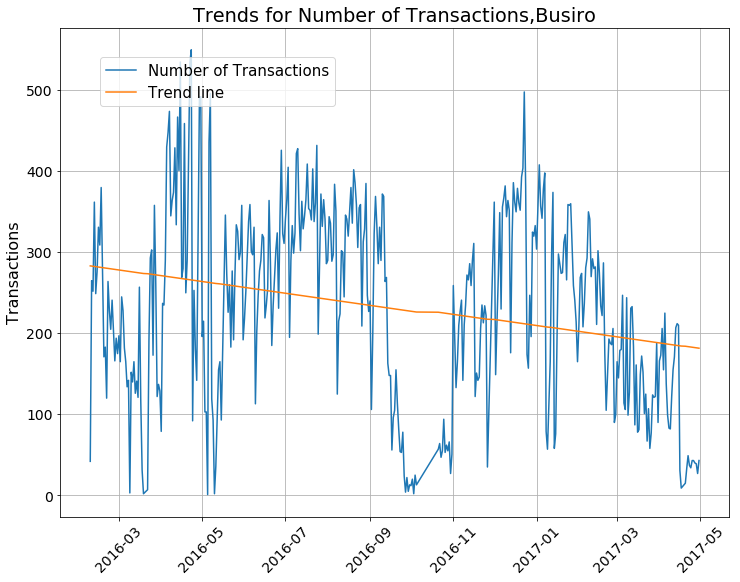

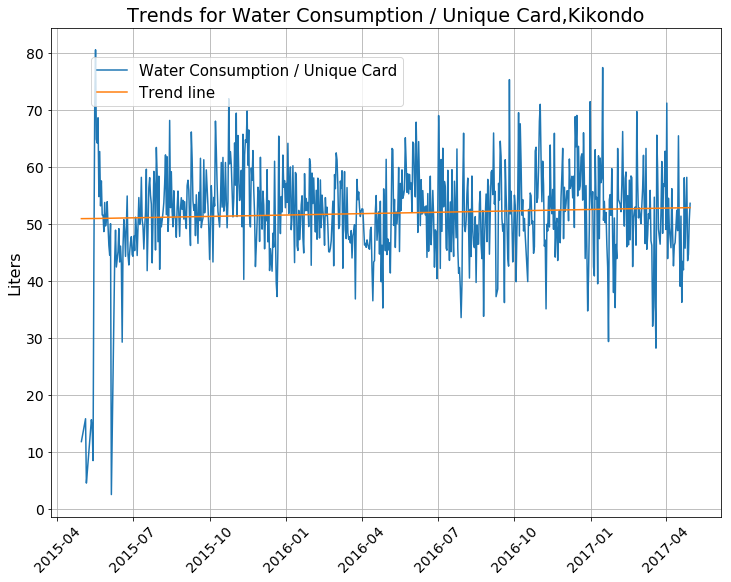

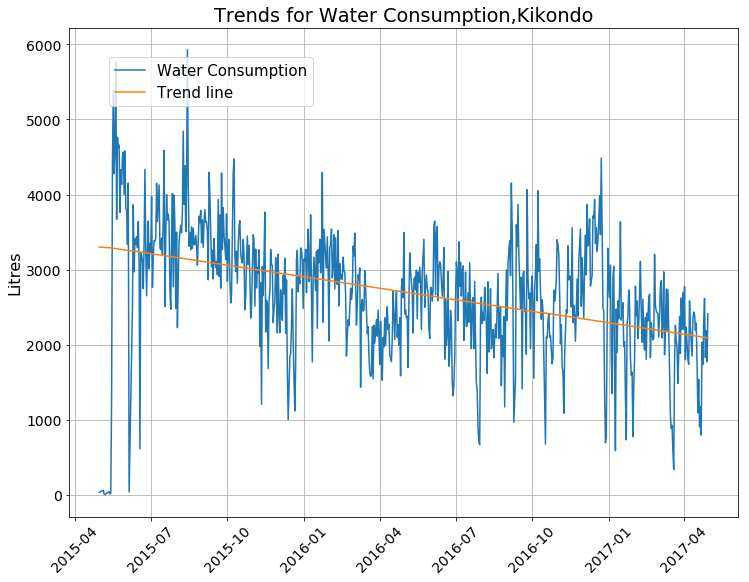

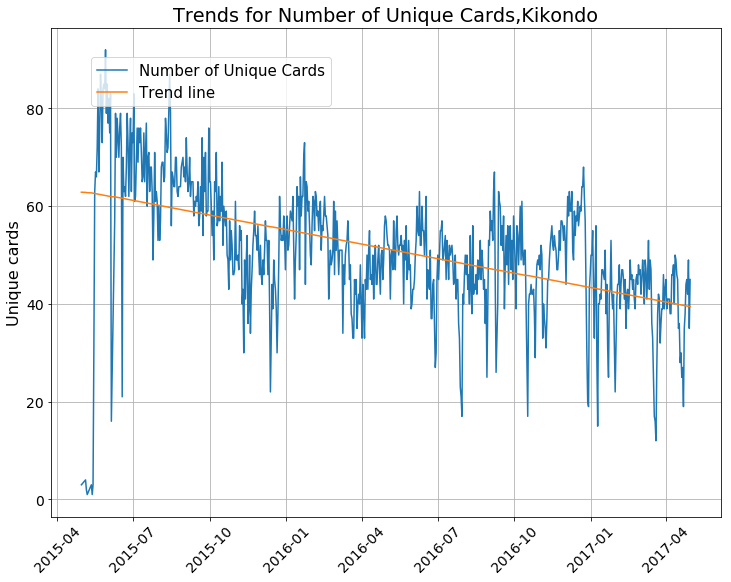

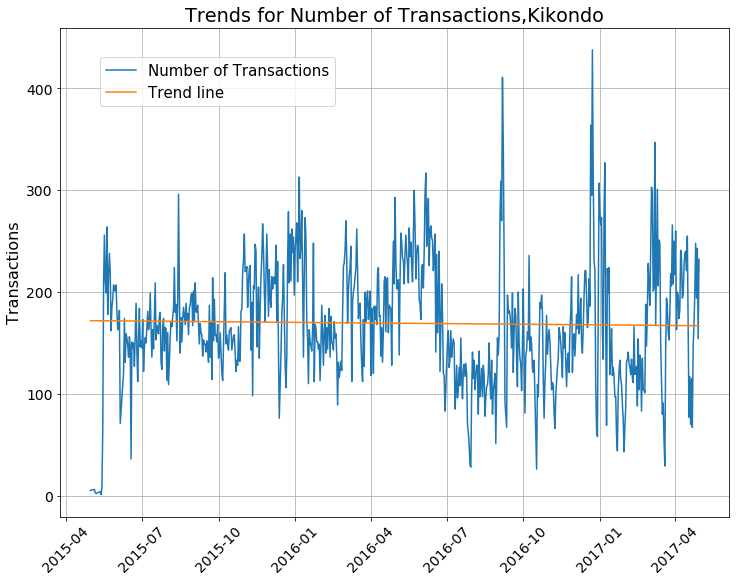

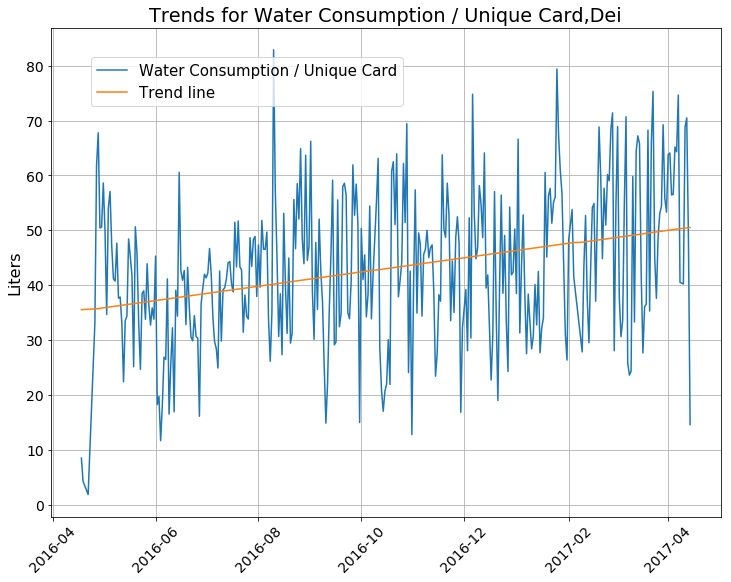

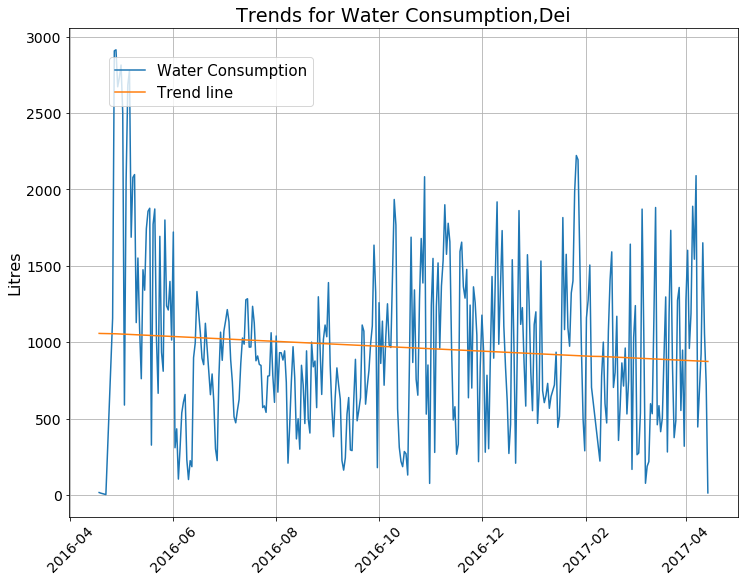

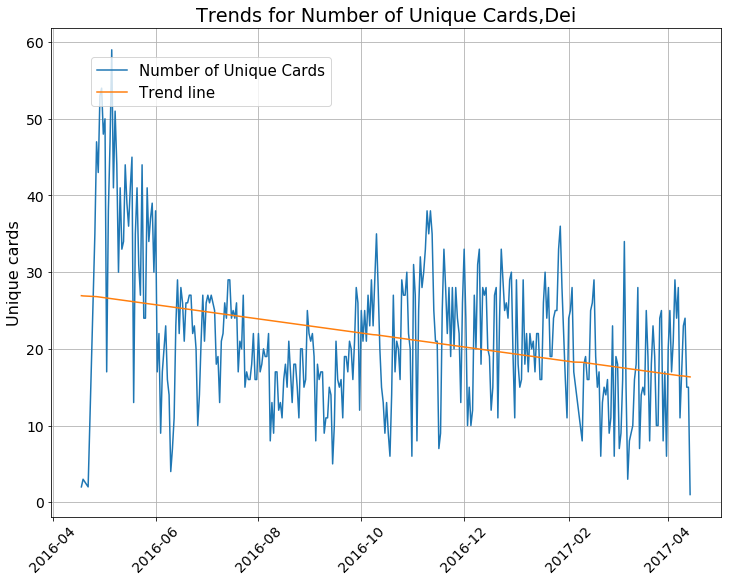

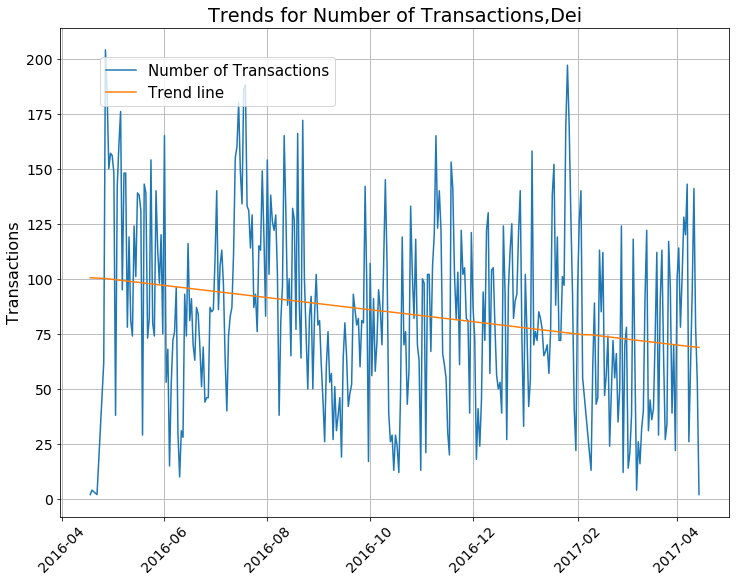

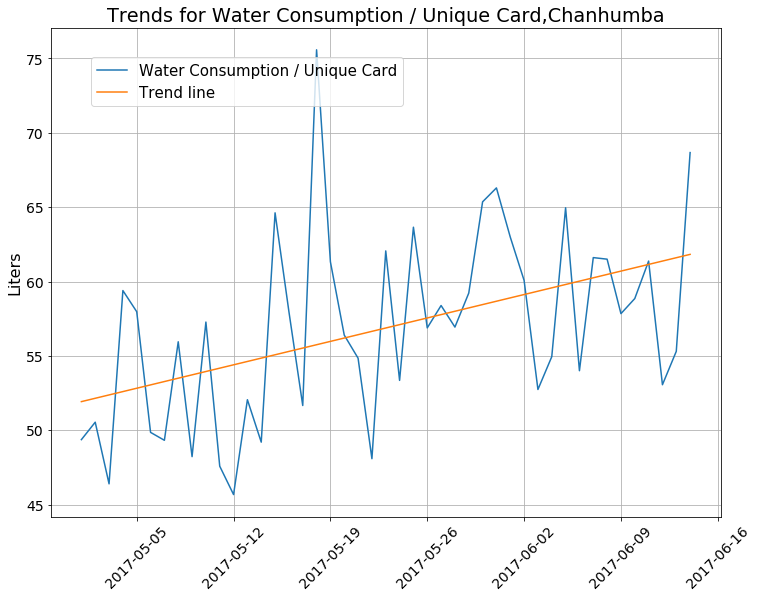

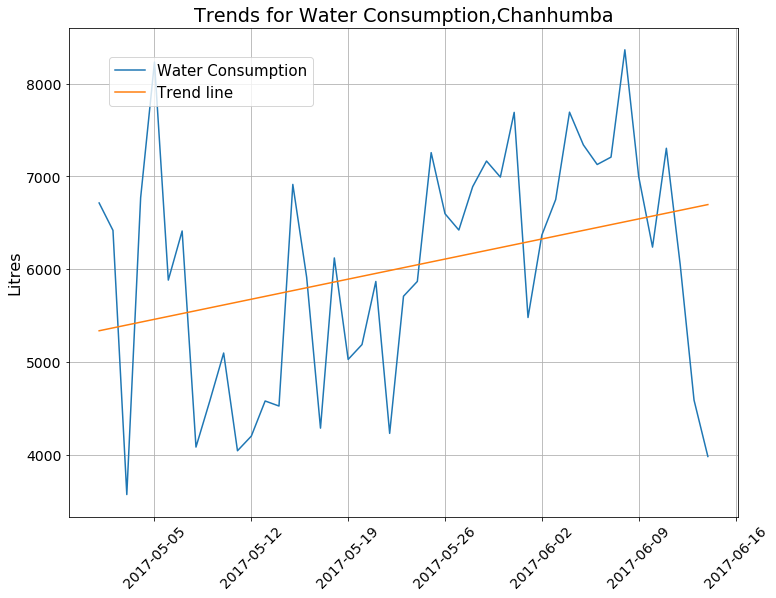

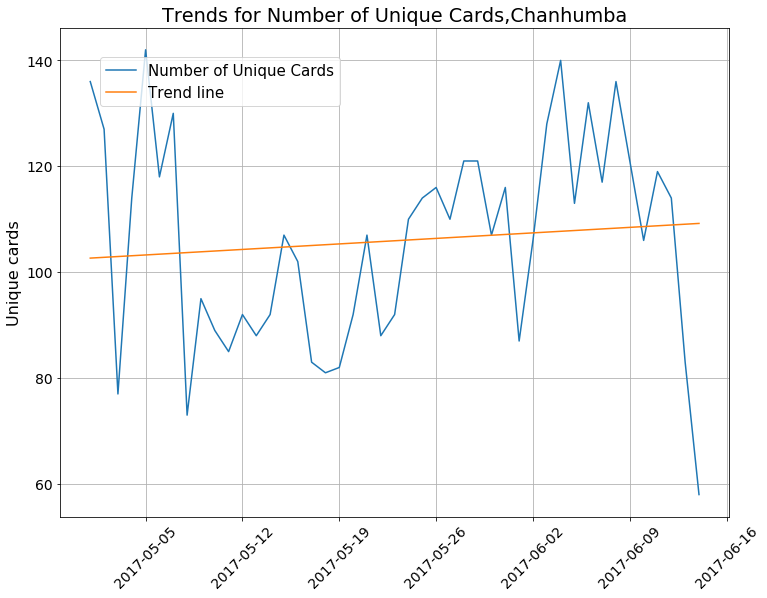

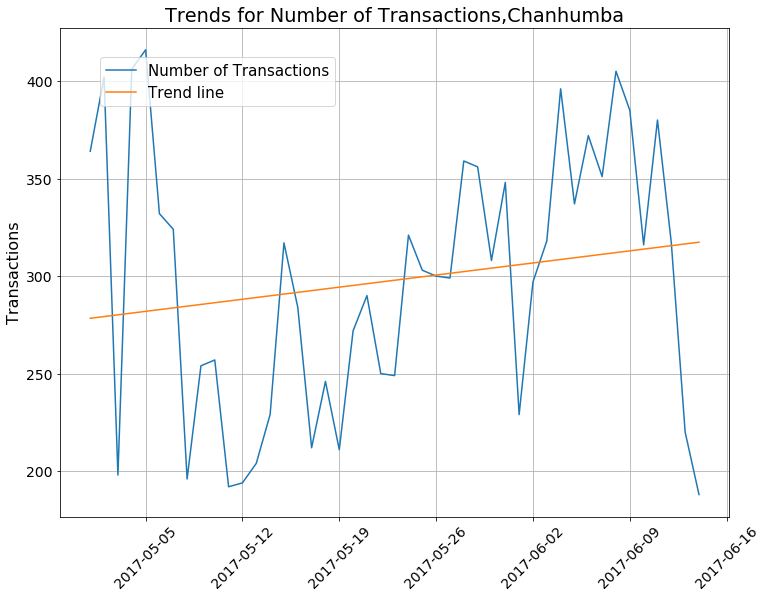

In [44]:
def showTrendForAllLocations(key, weeksToTrim, showAverage, showLegend, distr):
    legend = list()
    for district in datasets.keys():
        if(district == distr):
            data = trimInitialWeeks(datasets[district], int(weeksToTrim))
            data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
            data = data.sort_values('date', ascending = True).reset_index(drop = True)        
            x = data.date
            y = data[series[key]['field']]

            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 12
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
            ax = plt.axes()
            ax.yaxis.grid(True)
            ax.xaxis.grid(True)
            ax.set_ylabel(series[key]['measure'])

            # calc 10-day average
            if showAverage:
                plt.plot(x, y ,"-")
                legend.append(key)

            # calc the trendline
            i = x.index
            z = np.polyfit(i, y, 1)
            p = np.poly1d(z)

            t = data.index.map(lambda x: p(x))
            plt.plot(x, p(i),"-")
            legend.append('Trend line')
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Trends for ' + key + ',' + distr)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    if(showLegend):
        plt.legend(legend, bbox_to_anchor=(0.06, 0.94), loc=2, borderaxespad=0., fontsize=15)
    
    plt.show()

    #return data
series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}
          }

weeksToTrim = 0
showAverage = True
showLegend = True

       
for district in districts:
    for s in series:
        if(d == 'Chanhumba'):
            showTrendForAllLocations(s, 0, showAverage, showLegend, district)        
        else:
            showTrendForAllLocations(s, weeksToTrim, showAverage, showLegend, district)

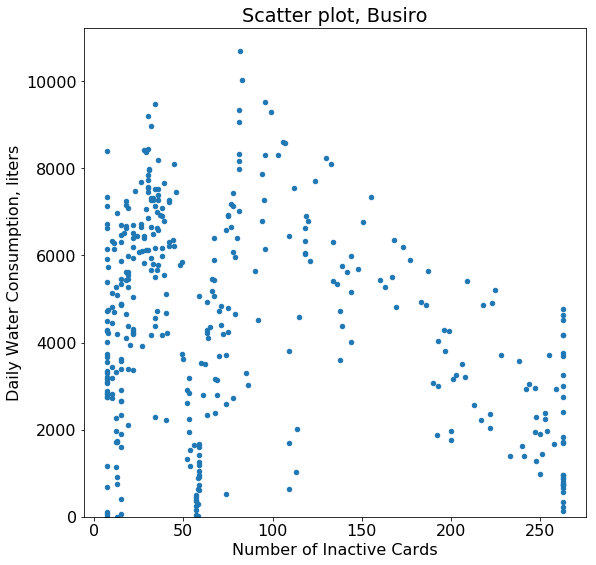

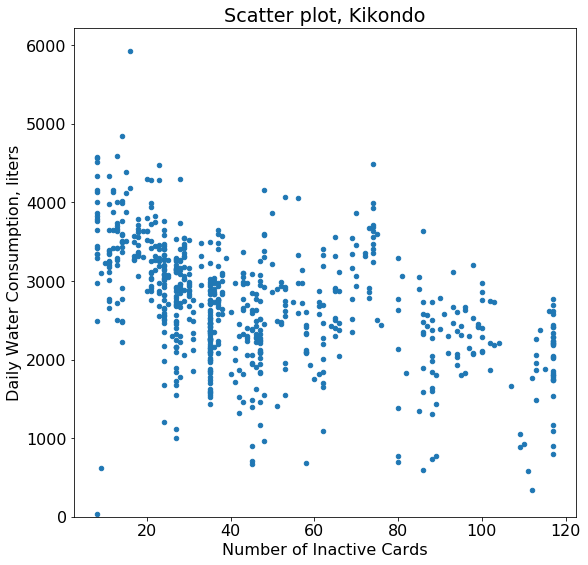

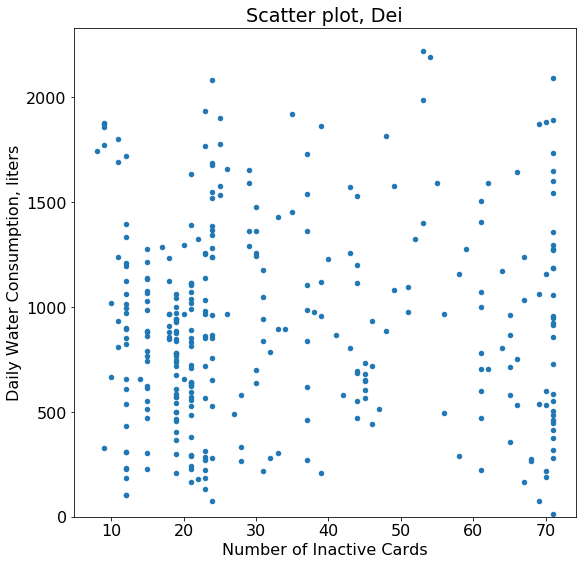

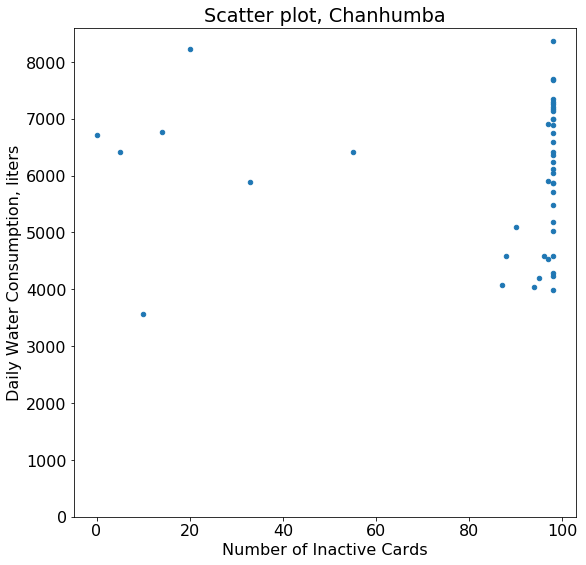

In [45]:
def showScatterAmountInactive(district, weeksToTrim):
    data = trimInitialWeeks(datasets[district], int(weeksToTrim))
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 9
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    data = data[['inactive_cards', 'amount']]
    data.columns = ['Number of Inactive Cards', 'Daily Water Consumption, liters']
    
    data.plot(kind='scatter', x='Number of Inactive Cards', y='Daily Water Consumption, liters')
    plt.title('Scatter plot, ' + district)
    plt.ylim(ymin=0)

weeksToTrim = 4

for d in districts:
    if(d == 'Chanhumba'):
        showScatterAmountInactive(d, 0)
    else:
        showScatterAmountInactive(d, weeksToTrim)

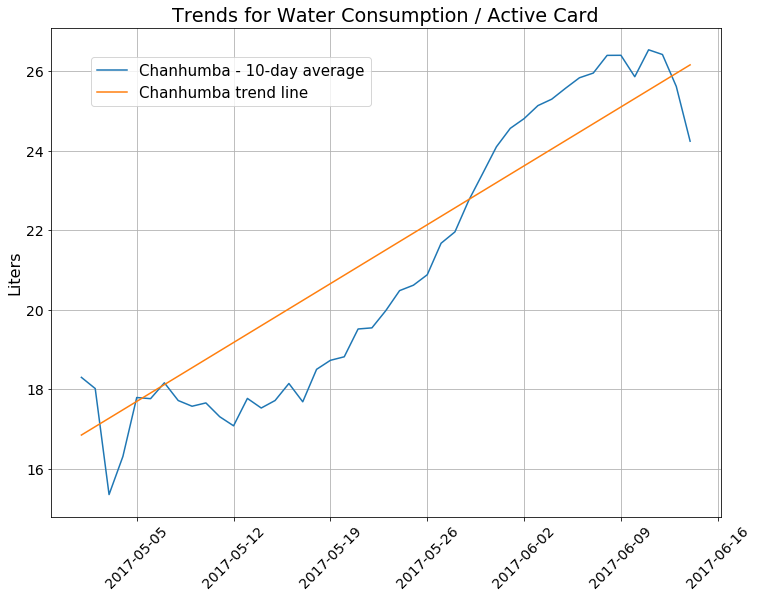

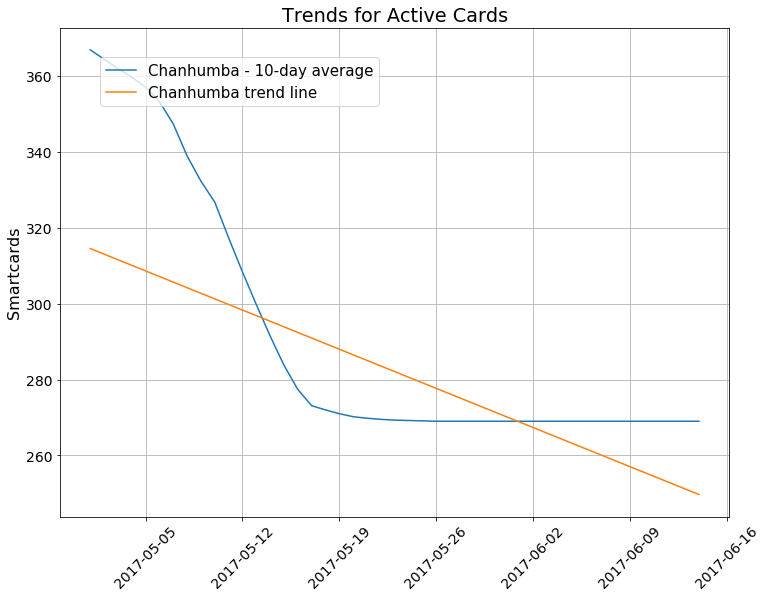

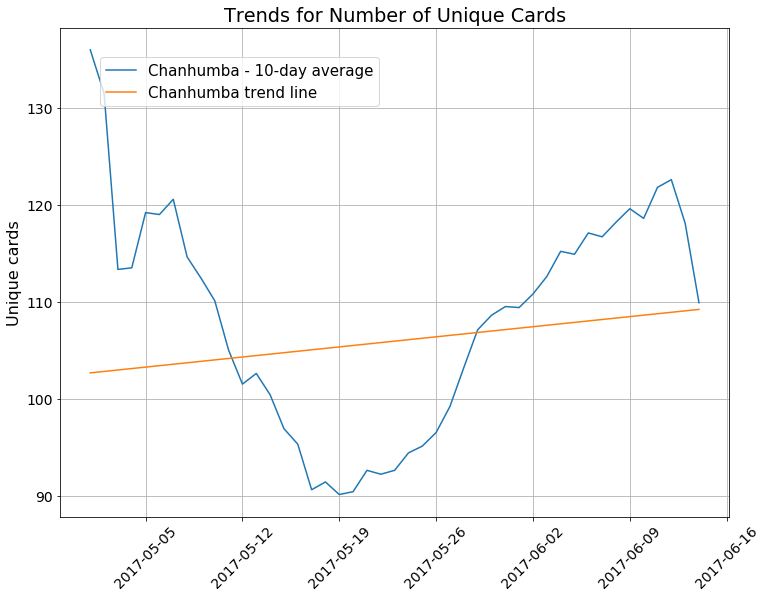

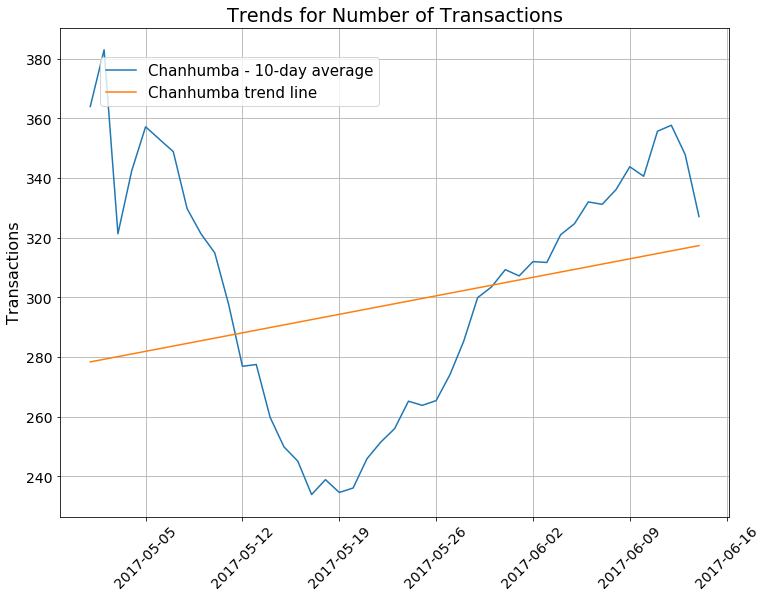

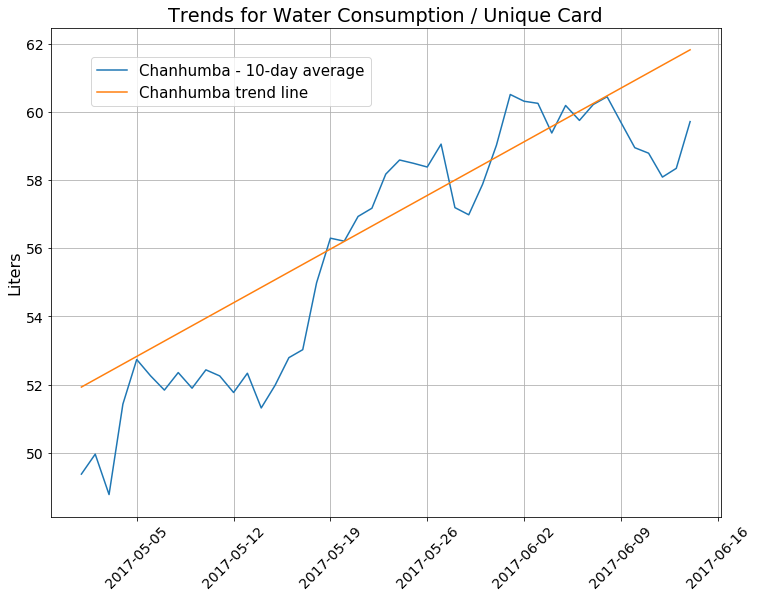

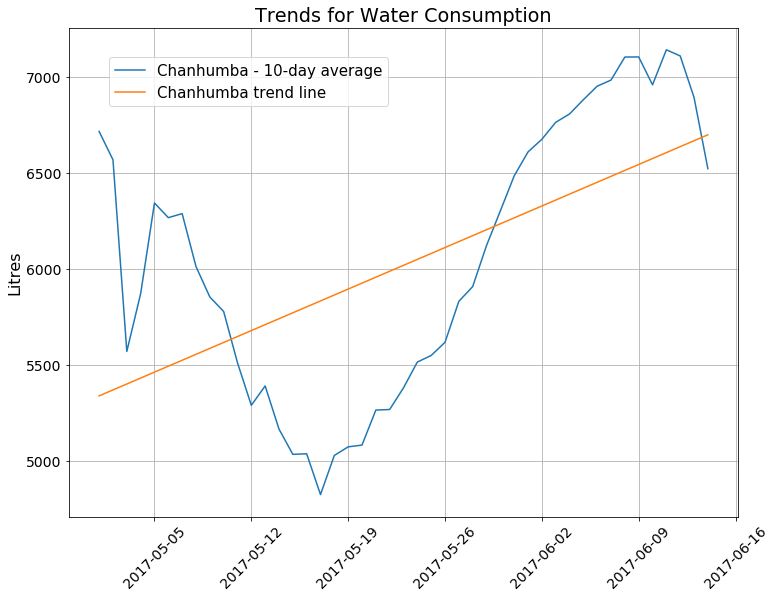

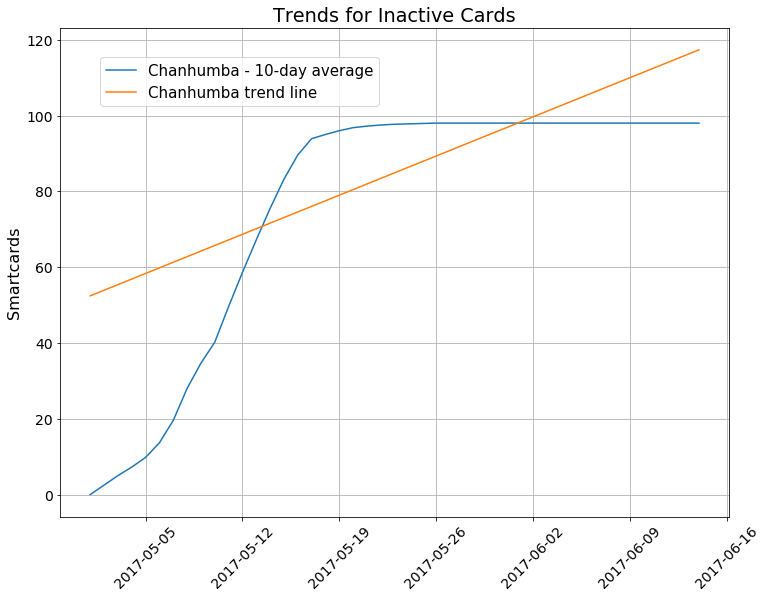

In [46]:
def showTrendForAllLocations(key, weeksToTrim, showAverage, showPoints, showLegend):
    legend = list()
    for district in datasets.keys():
        if(district == 'Chanhumba'):
            data = trimInitialWeeks(datasets[district], int(weeksToTrim))
            data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
            data = data.sort_values('date', ascending = True).reset_index(drop = True)        
            x = data.date
            y = data[series[key]['field']]

            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 12
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
            ax = plt.axes()
            ax.yaxis.grid(True)
            ax.xaxis.grid(True)
            ax.set_ylabel(series[key]['measure'])

            if showPoints:
                plt.plot(x, y, '-')
                legend.append(district)

            # calc 10-day average
            if showAverage:
                plt.plot(x, movingAverage(y, 10) ,"-")
                legend.append(district + " - 10-day average")

            # calc the trendline
            i = x.index
            z = np.polyfit(i, y, 1)
            p = np.poly1d(z)

            t = data.index.map(lambda x: p(x))
            plt.plot(x, p(i),"-")
            legend.append(district + ' trend line')
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Trends for ' + key)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    if(showLegend):
        plt.legend(legend, bbox_to_anchor=(0.06, 0.94), loc=2, borderaxespad=0., fontsize=15)
    
    plt.show()

    #return data
series = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'},
          'Active Cards':{'field':'active_cards', 'measure':'Smartcards'},
          'Inactive Cards':{'field':'inactive_cards', 'measure':'Smartcards'},
          'Water Consumption / Active Card':{'field':'amount_per_active_card', 'measure':'Liters'}}

weeksToTrim = 0
showAverage = True
showPoints = False
showLegend = True

for s in series:
    showTrendForAllLocations(s, weeksToTrim, showAverage, showPoints, showLegend)